Made in Google Colab

In [391]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 
import scipy.cluster.hierarchy as sch
import datetime

In [392]:
from sklearn.cluster import KMeans

# center and scale the data
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis

In [393]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [394]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [395]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [396]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64') |(x.dtypes == 'int32') | (x.dtypes == 'float32'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode().iloc[0])
    return x

Import Data

In [397]:
from google.colab import files
uploaded=files.upload()

Saving CustomersData.xlsx to CustomersData (2).xlsx


In [398]:
import io
customer= pd.read_excel(io.BytesIO(uploaded['CustomersData.xlsx']))

In [399]:
customer

,CustomerID,Gender,Location,Tenure_Months
0,17850,M,Chicago,12
1,13047,M,California,43
2,12583,M,Chicago,33
3,13748,F,California,30
4,15100,M,California,49
...,...,...,...,...
1463,14438,F,New York,41
1464,12956,F,Chicago,48
1465,15781,M,New Jersey,19
1466,14410,F,New York,45


In [400]:
from google.colab import files
uploaded=files.upload()

Saving Discount_Coupon.csv to Discount_Coupon (2).csv


In [401]:
import io
dis= pd.read_csv(io.BytesIO(uploaded['Discount_Coupon.csv']))

In [402]:
dis
#dis.info()

,Month,Product_Category,Coupon_Code,Discount_pct
0,Jan,Apparel,SALE10,10
1,Feb,Apparel,SALE20,20
2,Mar,Apparel,SALE30,30
3,Jan,Nest-USA,ELEC10,10
4,Feb,Nest-USA,ELEC20,20
...,...,...,...,...
199,Nov,Notebooks & Journals,NJ20,20
200,Dec,Notebooks & Journals,NJ30,30
201,Oct,Android,AND10,10
202,Nov,Android,AND20,20


In [403]:
from google.colab import files
uploaded=files.upload()

Saving Marketing_Spend.csv to Marketing_Spend (2).csv


In [404]:
import io
markt= pd.read_csv(io.BytesIO(uploaded['Marketing_Spend.csv']))

In [405]:
markt

,Date,Offline_Spend,Online_Spend
0,1/1/2019,4500,2424.50
1,1/2/2019,4500,3480.36
2,1/3/2019,4500,1576.38
3,1/4/2019,4500,2928.55
4,1/5/2019,4500,4055.30
...,...,...,...
360,12/27/2019,4000,3396.87
361,12/28/2019,4000,3246.84
362,12/29/2019,4000,2546.58
363,12/30/2019,4000,674.31


In [406]:
from google.colab import files
uploaded=files.upload()

Saving Online_Sales.csv to Online_Sales (2).csv


In [407]:
import io
online_sales= pd.read_csv(io.BytesIO(uploaded['Online_Sales.csv']))

In [408]:
online_sales

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status
0,17850,16679,20190101,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used
1,17850,16680,20190101,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used
2,17850,16681,20190101,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.50,Used
3,17850,16682,20190101,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.50,Not Used
4,17850,16682,20190101,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.50,Used
...,...,...,...,...,...,...,...,...,...,...
52919,14410,48493,20191231,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Nest-USA,1,121.30,6.50,Clicked
52920,14410,48494,20191231,GGOEGAEB091117,Google Zip Hoodie Black,Apparel,1,48.92,6.50,Used
52921,14410,48495,20191231,GGOENEBQ084699,Nest Learning Thermostat 3rd Gen-USA - White,Nest-USA,1,151.88,6.50,Used
52922,14600,48496,20191231,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Nest-USA,5,80.52,6.50,Clicked


In [409]:
from google.colab import files
uploaded=files.upload()

Saving Tax_amount.xlsx to Tax_amount (2).xlsx


In [410]:
import io
tax= pd.read_excel(io.BytesIO(uploaded['Tax_amount.xlsx']))

In [411]:
tax

,Product_Category,GST
0,Nest-USA,0.10
1,Office,0.10
2,Apparel,0.18
3,Bags,0.18
4,Drinkware,0.18
5,Lifestyle,0.18
6,Notebooks & Journals,0.05
7,Headgear,0.05
8,Waze,0.18
9,Fun,0.18


In [412]:
customer.CustomerID.nunique()

1468

Merge datasets


In [413]:
online_sales_custmer =pd.merge(online_sales, customer, on = "CustomerID", how = "left")
o_c_t =pd.merge(online_sales_custmer, tax, on = "Product_Category", how="left")
#o_c_t.info()

In [414]:
o_c_t.Transaction_Date = pd.to_datetime(o_c_t.Transaction_Date, format = "%Y%m%d")
o_c_t['tx_Month'] = o_c_t.Transaction_Date.dt.strftime("%b")


In [415]:
o_c_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52924 entries, 0 to 52923
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CustomerID           52924 non-null  int64         
 1   Transaction_ID       52924 non-null  int64         
 2   Transaction_Date     52924 non-null  datetime64[ns]
 3   Product_SKU          52924 non-null  object        
 4   Product_Description  52924 non-null  object        
 5   Product_Category     52924 non-null  object        
 6   Quantity             52924 non-null  int64         
 7   Avg_Price            52924 non-null  float64       
 8   Delivery_Charges     52924 non-null  float64       
 9   Coupon_Status        52924 non-null  object        
 10  Gender               52924 non-null  object        
 11  Location             52924 non-null  object        
 12  Tenure_Months        52924 non-null  int64         
 13  GST                  52924 non-

In [416]:
# Now adding discount dataframe with the o_c_t 
df =pd.merge(o_c_t, dis,left_on=['tx_Month'], right_on = ['Month'], how = "inner")

In [417]:
#df.drop("tx_Month", axis= 1, inplace=True)

In [418]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 899708 entries, 0 to 899707
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   CustomerID           899708 non-null  int64         
 1   Transaction_ID       899708 non-null  int64         
 2   Transaction_Date     899708 non-null  datetime64[ns]
 3   Product_SKU          899708 non-null  object        
 4   Product_Description  899708 non-null  object        
 5   Product_Category     899708 non-null  object        
 6   Quantity             899708 non-null  int64         
 7   Avg_Price            899708 non-null  float64       
 8   Delivery_Charges     899708 non-null  float64       
 9   Coupon_Status        899708 non-null  object        
 10  Gender               899708 non-null  object        
 11  Location             899708 non-null  object        
 12  Tenure_Months        899708 non-null  int64         
 13  GST           

In [419]:
markt.head()

,Date,Offline_Spend,Online_Spend
0,1/1/2019,4500,2424.50
1,1/2/2019,4500,3480.36
2,1/3/2019,4500,1576.38
3,1/4/2019,4500,2928.55
4,1/5/2019,4500,4055.30


In [420]:
df.shape

(899708, 19)

let's see what the data looks like

### Basic Exploratory Data Analysis

In [421]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 899708 entries, 0 to 899707
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   CustomerID           899708 non-null  int64         
 1   Transaction_ID       899708 non-null  int64         
 2   Transaction_Date     899708 non-null  datetime64[ns]
 3   Product_SKU          899708 non-null  object        
 4   Product_Description  899708 non-null  object        
 5   Product_Category     899708 non-null  object        
 6   Quantity             899708 non-null  int64         
 7   Avg_Price            899708 non-null  float64       
 8   Delivery_Charges     899708 non-null  float64       
 9   Coupon_Status        899708 non-null  object        
 10  Gender               899708 non-null  object        
 11  Location             899708 non-null  object        
 12  Tenure_Months        899708 non-null  int64         
 13  GST           

In [422]:
df.columns

Index(['CustomerID', 'Transaction_ID', 'Transaction_Date', 'Product_SKU',
       'Product_Description', 'Product_Category', 'Quantity', 'Avg_Price',
       'Delivery_Charges', 'Coupon_Status', 'Gender', 'Location',
       'Tenure_Months', 'GST', 'tx_Month', 'Month', 'Product_Category ',
       'Coupon_Code', 'Discount_pct'],
      dtype='object')

In [423]:
df.shape

(899708, 19)

In [424]:
df.describe()

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct
count,899708.000000,899708.000000,899708.000000,899708.000000,899708.00000,899708.000000,899708.000000,899708.000000
mean,15346.709810,32409.825675,4.497638,52.237646,10.51763,26.127995,0.137462,19.943504
std,1766.540312,8648.592075,20.104532,64.006312,19.47544,13.478165,0.045824,8.127004
min,12346.000000,16679.000000,1.000000,0.390000,0.00000,2.000000,0.050000,10.000000
25%,13869.000000,25384.000000,1.000000,5.700000,6.00000,15.000000,0.100000,10.000000
50%,15311.000000,32625.500000,1.000000,16.990000,6.00000,27.000000,0.180000,20.000000
75%,16996.250000,39126.250000,2.000000,102.130000,6.50000,37.000000,0.180000,30.000000
max,18283.000000,48497.000000,900.000000,355.740000,521.36000,50.000000,0.180000,30.000000


In [425]:
# dropping variable
#df2.drop(columns='CustomerID',inplace=True)
#Missing valuess


In [426]:
df.isna().sum()

CustomerID             0
Transaction_ID         0
Transaction_Date       0
Product_SKU            0
Product_Description    0
Product_Category       0
Quantity               0
Avg_Price              0
Delivery_Charges       0
Coupon_Status          0
Gender                 0
Location               0
Tenure_Months          0
GST                    0
tx_Month               0
Month                  0
Product_Category       0
Coupon_Code            0
Discount_pct           0
dtype: int64

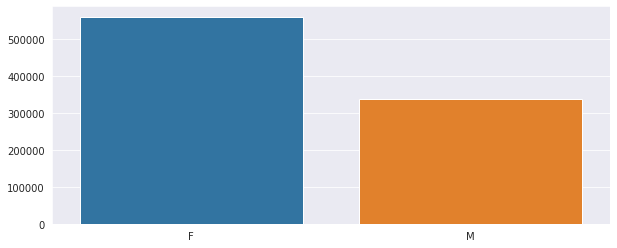

In [427]:
# Distribution of gender male and female
genders = df.Gender.value_counts()
sns.set_style("darkgrid")
plt.figure(figsize=(10,4))
sns.barplot(x=genders.index, y=genders.values)
plt.show()

In [428]:
# Checking duplicate values in the dataframe
df.duplicated().sum()

0

In [429]:
df.dtypes

CustomerID                      int64
Transaction_ID                  int64
Transaction_Date       datetime64[ns]
Product_SKU                    object
Product_Description            object
Product_Category               object
Quantity                        int64
Avg_Price                     float64
Delivery_Charges              float64
Coupon_Status                  object
Gender                         object
Location                       object
Tenure_Months                   int64
GST                           float64
tx_Month                       object
Month                          object
Product_Category               object
Coupon_Code                    object
Discount_pct                    int64
dtype: object

In [430]:
df.head(4)

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Gender,Location,Tenure_Months,GST,tx_Month,Month,Product_Category,Coupon_Code,Discount_pct
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,Jan,Apparel,SALE10,10
1,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,Jan,Nest-USA,ELEC10,10
2,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,Jan,Office,OFF10,10
3,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,Jan,Drinkware,EXTRA10,10


In [431]:
#define categorical list 
for x in ['Product_Category','Product_Description', 'Product_SKU','Coupon_Status',"Gender" ,"Coupon_Code"]:
    df[x]=df[x].astype('object')


In [432]:
# Separate numerical and categorical variable
# Find numerical variable in Data frame.
# This will return a list
numeric_var_names = [key for key in dict(df.dtypes) if dict(df.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]

# Find Categorical variable in Data frame
cat_var_names = [key for key in dict(df.dtypes) if dict(df.dtypes)[key] in ['object']]

#Print the data frame
print( numeric_var_names)
print(cat_var_names)

['CustomerID', 'Transaction_ID', 'Quantity', 'Avg_Price', 'Delivery_Charges', 'Tenure_Months', 'GST', 'Discount_pct']
['Product_SKU', 'Product_Description', 'Product_Category', 'Coupon_Status', 'Gender', 'Location', 'tx_Month', 'Month', 'Product_Category ', 'Coupon_Code']


In [433]:
#Convert a list in to dataframe 
#Information about numericvariable in custdata_df
df_num=df[numeric_var_names]
df_num

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct
0,17850,16679,1,153.71,6.50,12,0.1,10
1,17850,16679,1,153.71,6.50,12,0.1,10
2,17850,16679,1,153.71,6.50,12,0.1,10
3,17850,16679,1,153.71,6.50,12,0.1,10
4,17850,16679,1,153.71,6.50,12,0.1,10
...,...,...,...,...,...,...,...,...
899703,14600,48497,4,80.52,19.99,7,0.1,30
899704,14600,48497,4,80.52,19.99,7,0.1,30
899705,14600,48497,4,80.52,19.99,7,0.1,30
899706,14600,48497,4,80.52,19.99,7,0.1,30


In [434]:
#Convert a list in to dataframe 
#Information about categorical variable in custdata_df
df_cat=df[cat_var_names]
df_cat.head(5)

,Product_SKU,Product_Description,Product_Category,Coupon_Status,Gender,Location,tx_Month,Month,Product_Category,Coupon_Code
0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,Used,M,Chicago,Jan,Jan,Apparel,SALE10
1,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,Used,M,Chicago,Jan,Jan,Nest-USA,ELEC10
2,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,Used,M,Chicago,Jan,Jan,Office,OFF10
3,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,Used,M,Chicago,Jan,Jan,Drinkware,EXTRA10
4,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,Used,M,Chicago,Jan,Jan,Lifestyle,EXTRA10


In [435]:
#Handling outliers
#df_num=  df_num.apply(lambda x: x.clip(lower = x.quantile(0.01), upper = x.quantile(0.99)))
#df_num

### Missing Value Treatment


In [436]:
df_num = df_num.apply(missing_imputation)
df_num.apply(continuous_var_summary).T

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
CustomerID,899708.0,0.0,1.380756e+10,15346.709810,15311.00,1766.540312,3.120665e+06,12346.00,12413.00,12585.00,12782.00,13869.0,15311.00,16996.25,17799.00,17967.00,18179.00,18283.00
Transaction_ID,899708.0,0.0,2.915938e+10,32409.825675,32625.50,8648.592075,7.479814e+07,16679.00,17053.00,18487.00,20219.00,25384.0,32625.50,39126.25,44684.00,46554.00,48056.00,48497.00
Quantity,899708.0,0.0,4.046561e+06,4.497638,1.00,20.104532,4.041922e+02,1.00,1.00,1.00,1.00,1.0,1.00,2.00,6.00,16.00,60.00,900.00
Avg_Price,899708.0,0.0,4.699863e+07,52.237646,16.99,64.006312,4.096808e+03,0.39,0.99,1.99,2.79,5.7,16.99,102.13,149.00,151.88,279.00,355.74
Delivery_Charges,899708.0,0.0,9.462796e+06,10.517630,6.00,19.475440,3.792928e+02,0.00,6.00,6.00,6.00,6.0,6.00,6.50,15.37,26.43,75.00,521.36
Tenure_Months,899708.0,0.0,2.350757e+07,26.127995,27.00,13.478165,1.816609e+02,2.00,2.00,5.00,7.00,15.0,27.00,37.00,44.00,47.00,50.00,50.00
GST,899708.0,0.0,1.236755e+05,0.137462,0.18,0.045824,2.099873e-03,0.05,0.05,0.05,0.10,0.1,0.18,0.18,0.18,0.18,0.18,0.18
Discount_pct,899708.0,0.0,1.794333e+07,19.943504,20.00,8.127004,6.604820e+01,10.00,10.00,10.00,10.00,10.0,20.00,30.00,30.00,30.00,30.00,30.00


In [437]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 899708 entries, 0 to 899707
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CustomerID        899708 non-null  int64  
 1   Transaction_ID    899708 non-null  int64  
 2   Quantity          899708 non-null  int64  
 3   Avg_Price         899708 non-null  float64
 4   Delivery_Charges  899708 non-null  float64
 5   Tenure_Months     899708 non-null  int64  
 6   GST               899708 non-null  float64
 7   Discount_pct      899708 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 61.8 MB


In [438]:
df_cat = df_cat.apply(missing_imputation)
df_cat.apply(categorical_var_summary).T

,N,NMISS,MODE,FREQ,PERCENT
Product_SKU,899708,0,GGOENEBJ079499,59687,6.63
Product_Description,899708,0,Nest Learning Thermostat 3rd Gen-USA - Stainle...,59687,6.63
Product_Category,899708,0,Apparel,308142,34.25
Coupon_Status,899708,0,Clicked,457742,50.88
Gender,899708,0,F,561119,62.37
Location,899708,0,Chicago,312460,34.73
tx_Month,899708,0,Aug,104550,11.62
Month,899708,0,Aug,104550,11.62
Product_Category,899708,0,Apparel,52924,5.88
Coupon_Code,899708,0,EXTRA20,35934,3.99


In [439]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 899708 entries, 0 to 899707
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Product_SKU          899708 non-null  object
 1   Product_Description  899708 non-null  object
 2   Product_Category     899708 non-null  object
 3   Coupon_Status        899708 non-null  object
 4   Gender               899708 non-null  object
 5   Location             899708 non-null  object
 6   tx_Month             899708 non-null  object
 7   Month                899708 non-null  object
 8   Product_Category     899708 non-null  object
 9   Coupon_Code          899708 non-null  object
dtypes: object(10)
memory usage: 75.5+ MB


### Again check missing values has been treated or not


In [440]:
# Find the total number of missing values in the numerical data i.e custdata_df_num
print ("\nMissing values in numerical data :  ", df_num.isnull().sum().values.sum())
print ("\nMissing values in categorical data :  ", df_cat.isnull().sum().values.sum())


Missing values in numerical data :   0

Missing values in categorical data :   0


### Dummy creation for categorical data¶


In [441]:
df_cat.nunique()

Product_SKU            1145
Product_Description     404
Product_Category         20
Coupon_Status             3
Gender                    2
Location                  5
tx_Month                 12
Month                    12
Product_Category         17
Coupon_Code              48
dtype: int64

In [442]:
df_cat.isnull().sum()


Product_SKU            0
Product_Description    0
Product_Category       0
Coupon_Status          0
Gender                 0
Location               0
tx_Month               0
Month                  0
Product_Category       0
Coupon_Code            0
dtype: int64

In [443]:
# We need to create a function for dummy creation
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname)
    col_dummies.drop(col_dummies.columns[0], axis = 1, inplace = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True)
    return df

In [444]:
df_cat=df.select_dtypes(include=['object'])
df_cat

,Product_SKU,Product_Description,Product_Category,Coupon_Status,Gender,Location,tx_Month,Month,Product_Category,Coupon_Code
0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,Used,M,Chicago,Jan,Jan,Apparel,SALE10
1,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,Used,M,Chicago,Jan,Jan,Nest-USA,ELEC10
2,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,Used,M,Chicago,Jan,Jan,Office,OFF10
3,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,Used,M,Chicago,Jan,Jan,Drinkware,EXTRA10
4,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,Used,M,Chicago,Jan,Jan,Lifestyle,EXTRA10
...,...,...,...,...,...,...,...,...,...,...
899703,GGOENEBQ079099,Nest Protect Smoke + CO White Battery Alarm-USA,Nest-USA,Clicked,F,California,Dec,Dec,Housewares,HOU30
899704,GGOENEBQ079099,Nest Protect Smoke + CO White Battery Alarm-USA,Nest-USA,Clicked,F,California,Dec,Dec,Accessories,ACC30
899705,GGOENEBQ079099,Nest Protect Smoke + CO White Battery Alarm-USA,Nest-USA,Clicked,F,California,Dec,Dec,Gift Cards,GC30
899706,GGOENEBQ079099,Nest Protect Smoke + CO White Battery Alarm-USA,Nest-USA,Clicked,F,California,Dec,Dec,Notebooks & Journals,NJ30


In [445]:
df_cat2 =df_cat.iloc[ :, [0,1,6,7]]
df_cat2

,Product_SKU,Product_Description,tx_Month,Month
0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,Jan
1,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,Jan
2,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,Jan
3,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,Jan
4,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,Jan
...,...,...,...,...
899703,GGOENEBQ079099,Nest Protect Smoke + CO White Battery Alarm-USA,Dec,Dec
899704,GGOENEBQ079099,Nest Protect Smoke + CO White Battery Alarm-USA,Dec,Dec
899705,GGOENEBQ079099,Nest Protect Smoke + CO White Battery Alarm-USA,Dec,Dec
899706,GGOENEBQ079099,Nest Protect Smoke + CO White Battery Alarm-USA,Dec,Dec


In [446]:
df_cat1 = df_cat.iloc[ :,[2,3,4,5]]
df_cat1

,Product_Category,Coupon_Status,Gender,Location
0,Nest-USA,Used,M,Chicago
1,Nest-USA,Used,M,Chicago
2,Nest-USA,Used,M,Chicago
3,Nest-USA,Used,M,Chicago
4,Nest-USA,Used,M,Chicago
...,...,...,...,...
899703,Nest-USA,Clicked,F,California
899704,Nest-USA,Clicked,F,California
899705,Nest-USA,Clicked,F,California
899706,Nest-USA,Clicked,F,California


In [447]:
cat_varlist=list(df_cat1.columns)
cat_varlist

['Product_Category', 'Coupon_Status', 'Gender', 'Location']

In [448]:
# For customer_features in categorical features

for c_feature in cat_varlist:
    df_cat1[c_feature]=df_cat1[c_feature].astype('category')
    df_cat1=create_dummies(df_cat1,c_feature)

<ipython-input-448-095aebffdd5b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat1[c_feature]=df_cat1[c_feature].astype('category')


In [449]:
df_cat1.sample(5)

,Product_Category_Android,Product_Category_Apparel,Product_Category_Backpacks,Product_Category_Bags,Product_Category_Bottles,Product_Category_Drinkware,Product_Category_Fun,Product_Category_Gift Cards,Product_Category_Google,Product_Category_Headgear,...,Product_Category_Notebooks & Journals,Product_Category_Office,Product_Category_Waze,Coupon_Status_Not Used,Coupon_Status_Used,Gender_M,Location_Chicago,Location_New Jersey,Location_New York,Location_Washington DC
557201,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
844225,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
108513,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
708099,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
506175,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [450]:
## Merge Numerical and categorical data
df_fin = pd.concat([df_num, df_cat1,df_cat2,  df.Transaction_Date], axis=1)
df_fin.head()

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Gender_M,Location_Chicago,Location_New Jersey,Location_New York,Location_Washington DC,Product_SKU,Product_Description,tx_Month,Month,Transaction_Date
0,17850,16679,1,153.71,6.5,12,0.1,10,0,0,...,1,1,0,0,0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,Jan,2019-01-01
1,17850,16679,1,153.71,6.5,12,0.1,10,0,0,...,1,1,0,0,0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,Jan,2019-01-01
2,17850,16679,1,153.71,6.5,12,0.1,10,0,0,...,1,1,0,0,0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,Jan,2019-01-01
3,17850,16679,1,153.71,6.5,12,0.1,10,0,0,...,1,1,0,0,0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,Jan,2019-01-01
4,17850,16679,1,153.71,6.5,12,0.1,10,0,0,...,1,1,0,0,0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,Jan,2019-01-01


In [451]:
df_fin.shape

(899708, 39)

In [452]:
df_fin.duplicated().sum()

846784

In [453]:
df_fin.drop_duplicates(inplace= True)

In [454]:
df_fin.duplicated().sum()

0

## Business Objective:


### The e-commerce company is expecting below analysis using the data

### 1. Calculate Invoice amount or sale_amount or revenue for each transaction and item level.
###Invoice Value =(( QuantityAvg_price)(1-Dicount_pct)*(1+GST))+Delivery_Charges

In [455]:
df_fin.head()

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Gender_M,Location_Chicago,Location_New Jersey,Location_New York,Location_Washington DC,Product_SKU,Product_Description,tx_Month,Month,Transaction_Date
0,17850,16679,1,153.71,6.5,12,0.10,10,0,0,...,1,1,0,0,0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,Jan,2019-01-01
17,17850,16680,1,153.71,6.5,12,0.10,10,0,0,...,1,1,0,0,0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,Jan,2019-01-01
34,17850,16681,1,2.05,6.5,12,0.10,10,0,0,...,1,1,0,0,0,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Jan,Jan,2019-01-01
51,17850,16682,5,17.53,6.5,12,0.18,10,0,1,...,1,1,0,0,0,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Jan,Jan,2019-01-01
68,17850,16682,1,16.50,6.5,12,0.18,10,0,0,...,1,1,0,0,0,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Jan,Jan,2019-01-01


In [456]:
df_fin['Invoice_value'] = df_fin['Quantity']*df_fin['Avg_Price']*1-df_fin['Discount_pct']*1+df_fin['GST']+df_fin.Delivery_Charges

In [457]:
df_fin.shape

(52924, 40)

In [458]:
df_fin.duplicated().sum()

0

In [459]:
df_fin.CustomerID.nunique()

1468

In [460]:
df_fin['Invoice_value'].sum()

4179214.7199999997

In [461]:
#df_fin['Average_order_value'] = df_fin['Invoice_value'] / df_fin['Invoice_value'].sum()
#df_fin
df_fin1 = df_fin   ## Make a copy of final dateset for model building using k-means
df_fin_CLTV = df ## Make a copy for predicting customer life time value 
df_fin3 = df ### For cross selling

### 2. Perform Detailed Exploratory Analysis


In [462]:
#total number of products, transactions, and customers in the data
#d={'Products':df_fin.Product_SKU.nunique(), "Tranx" : df_fin.Transaction_ID.nunique(), "Coustmers" : df_fin.CustomerID.nunique()}

In [463]:
pd.DataFrame([{'products': len(df_fin['Product_SKU'].value_counts()),    
               'transactions': len(df_fin['Transaction_ID'].value_counts()),
               'customers': len(df_fin['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,1145,25061,1468


In [464]:
#Now I will determine the number of products purchased in every transaction:
df_fin.columns

Index(['CustomerID', 'Transaction_ID', 'Quantity', 'Avg_Price',
       'Delivery_Charges', 'Tenure_Months', 'GST', 'Discount_pct',
       'Product_Category_Android', 'Product_Category_Apparel',
       'Product_Category_Backpacks', 'Product_Category_Bags',
       'Product_Category_Bottles', 'Product_Category_Drinkware',
       'Product_Category_Fun', 'Product_Category_Gift Cards',
       'Product_Category_Google', 'Product_Category_Headgear',
       'Product_Category_Housewares', 'Product_Category_Lifestyle',
       'Product_Category_More Bags', 'Product_Category_Nest',
       'Product_Category_Nest-Canada', 'Product_Category_Nest-USA',
       'Product_Category_Notebooks & Journals', 'Product_Category_Office',
       'Product_Category_Waze', 'Coupon_Status_Not Used', 'Coupon_Status_Used',
       'Gender_M', 'Location_Chicago', 'Location_New Jersey',
       'Location_New York', 'Location_Washington DC', 'Product_SKU',
       'Product_Description', 'tx_Month', 'Month', 'Transaction_Date',

In [465]:
temp = df_fin.groupby(by=['CustomerID', 'Transaction_ID'], as_index=False)['Transaction_Date'].count()
nb_products_per_basket = temp.rename(columns = {'Transaction_Date':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,Transaction_ID,Number of products
0,12346,38223,2
1,12347,23979,2
2,12347,23980,2
3,12347,23981,5
4,12347,23984,5
5,12347,23985,1
6,12347,23986,1
7,12347,23987,1
8,12347,23989,1
9,12347,23990,2


### 2.1 Understanding how many customers acquired every month


In [466]:
df_fin['tx_month'] = df_fin.Transaction_Date.dt.strftime("%b")
df_fin['tx_year'] = df_fin.Transaction_Date.dt.strftime("%Y")
df_fin['tx_day'] = df_fin.Transaction_Date.dt.strftime("%d")

In [467]:
df_fin.head()


,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Location_Washington DC,Product_SKU,Product_Description,tx_Month,Month,Transaction_Date,Invoice_value,tx_month,tx_year,tx_day
0,17850,16679,1,153.71,6.5,12,0.10,10,0,0,...,0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,Jan,2019-01-01,150.31,Jan,2019,01
17,17850,16680,1,153.71,6.5,12,0.10,10,0,0,...,0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,Jan,2019-01-01,150.31,Jan,2019,01
34,17850,16681,1,2.05,6.5,12,0.10,10,0,0,...,0,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Jan,Jan,2019-01-01,-1.35,Jan,2019,01
51,17850,16682,5,17.53,6.5,12,0.18,10,0,1,...,0,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Jan,Jan,2019-01-01,84.33,Jan,2019,01
68,17850,16682,1,16.50,6.5,12,0.18,10,0,0,...,0,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Jan,Jan,2019-01-01,13.18,Jan,2019,01


In [468]:
#We can creat a  flag that customer has one or more than one transaction for the particular month 


In [469]:
df_fin


,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Location_Washington DC,Product_SKU,Product_Description,tx_Month,Month,Transaction_Date,Invoice_value,tx_month,tx_year,tx_day
0,17850,16679,1,153.71,6.50,12,0.10,10,0,0,...,0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,Jan,2019-01-01,150.31,Jan,2019,01
17,17850,16680,1,153.71,6.50,12,0.10,10,0,0,...,0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,Jan,2019-01-01,150.31,Jan,2019,01
34,17850,16681,1,2.05,6.50,12,0.10,10,0,0,...,0,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Jan,Jan,2019-01-01,-1.35,Jan,2019,01
51,17850,16682,5,17.53,6.50,12,0.18,10,0,1,...,0,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Jan,Jan,2019-01-01,84.33,Jan,2019,01
68,17850,16682,1,16.50,6.50,12,0.18,10,0,0,...,0,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Jan,Jan,2019-01-01,13.18,Jan,2019,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899623,14410,48493,1,121.30,6.50,45,0.10,30,0,0,...,0,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Dec,Dec,2019-12-31,97.90,Dec,2019,31
899640,14410,48494,1,48.92,6.50,45,0.18,30,0,1,...,0,GGOEGAEB091117,Google Zip Hoodie Black,Dec,Dec,2019-12-31,25.60,Dec,2019,31
899657,14410,48495,1,151.88,6.50,45,0.10,30,0,0,...,0,GGOENEBQ084699,Nest Learning Thermostat 3rd Gen-USA - White,Dec,Dec,2019-12-31,128.48,Dec,2019,31
899674,14600,48496,5,80.52,6.50,7,0.10,30,0,0,...,0,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Dec,Dec,2019-12-31,379.20,Dec,2019,31


In [470]:
#Groupby customer id and find min transaction date for each customer
cust_kpi = pd.DataFrame(df_fin.groupby('CustomerID').Transaction_Date.min())
cust_kpi= cust_kpi.rename(columns= {'Transaction_Date' : 'First_tx_Date'}).reset_index()
cust_kpi


,CustomerID,First_tx_Date
0,12346,2019-09-15
1,12347,2019-03-24
2,12348,2019-06-22
3,12350,2019-12-14
4,12356,2019-09-15
...,...,...
1463,18259,2019-04-05
1464,18260,2019-06-22
1465,18269,2019-04-05
1466,18277,2019-10-23


In [471]:
df_fin = pd.merge(df_fin, cust_kpi, on = 'CustomerID', how = 'inner')
df_fin

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Product_SKU,Product_Description,tx_Month,Month,Transaction_Date,Invoice_value,tx_month,tx_year,tx_day,First_tx_Date
0,17850,16679,1,153.71,6.50,12,0.10,10,0,0,...,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,Jan,2019-01-01,150.31,Jan,2019,01,2019-01-01
1,17850,16680,1,153.71,6.50,12,0.10,10,0,0,...,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,Jan,2019-01-01,150.31,Jan,2019,01,2019-01-01
2,17850,16681,1,2.05,6.50,12,0.10,10,0,0,...,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Jan,Jan,2019-01-01,-1.35,Jan,2019,01,2019-01-01
3,17850,16682,5,17.53,6.50,12,0.18,10,0,1,...,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Jan,Jan,2019-01-01,84.33,Jan,2019,01,2019-01-01
4,17850,16682,1,16.50,6.50,12,0.18,10,0,0,...,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Jan,Jan,2019-01-01,13.18,Jan,2019,01,2019-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52919,14410,48493,1,121.30,6.50,45,0.10,30,0,0,...,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Dec,Dec,2019-12-31,97.90,Dec,2019,31,2019-12-31
52920,14410,48494,1,48.92,6.50,45,0.18,30,0,1,...,GGOEGAEB091117,Google Zip Hoodie Black,Dec,Dec,2019-12-31,25.60,Dec,2019,31,2019-12-31
52921,14410,48495,1,151.88,6.50,45,0.10,30,0,0,...,GGOENEBQ084699,Nest Learning Thermostat 3rd Gen-USA - White,Dec,Dec,2019-12-31,128.48,Dec,2019,31,2019-12-31
52922,14600,48496,5,80.52,6.50,7,0.10,30,0,0,...,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Dec,Dec,2019-12-31,379.20,Dec,2019,31,2019-12-31


In [472]:
#If the invoice date  of customer > min purchase date of that customer  than "existing" otherwise "new". customer
df_fin['customer_type'] = np.where(df_fin.Transaction_Date > df_fin.First_tx_Date, "Existing", "New")
df_fin.head(-100)

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Product_Description,tx_Month,Month,Transaction_Date,Invoice_value,tx_month,tx_year,tx_day,First_tx_Date,customer_type
0,17850,16679,1,153.71,6.5,12,0.10,10,0,0,...,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,Jan,2019-01-01,150.31,Jan,2019,01,2019-01-01,New
1,17850,16680,1,153.71,6.5,12,0.10,10,0,0,...,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,Jan,2019-01-01,150.31,Jan,2019,01,2019-01-01,New
2,17850,16681,1,2.05,6.5,12,0.10,10,0,0,...,Google Laptop and Cell Phone Stickers,Jan,Jan,2019-01-01,-1.35,Jan,2019,01,2019-01-01,New
3,17850,16682,5,17.53,6.5,12,0.18,10,0,1,...,Google Men's 100% Cotton Short Sleeve Hero Tee...,Jan,Jan,2019-01-01,84.33,Jan,2019,01,2019-01-01,New
4,17850,16682,1,16.50,6.5,12,0.18,10,0,0,...,Google Canvas Tote Natural/Navy,Jan,Jan,2019-01-01,13.18,Jan,2019,01,2019-01-01,New
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52819,13584,48319,1,121.30,6.5,35,0.10,30,0,0,...,Nest Cam Indoor Security Camera - USA,Dec,Dec,2019-12-28,97.90,Dec,2019,28,2019-12-28,New
52820,13584,48319,1,151.88,6.5,35,0.10,30,0,0,...,Nest Learning Thermostat 3rd Gen-USA - White,Dec,Dec,2019-12-28,128.48,Dec,2019,28,2019-12-28,New
52821,13584,48322,3,3.25,6.5,35,0.18,30,0,0,...,Windup Android,Dec,Dec,2019-12-29,-13.57,Dec,2019,29,2019-12-28,Existing
52822,13584,48322,1,3.47,6.5,35,0.18,30,0,1,...,Google Women's Short Sleeve Badge Tee Grey,Dec,Dec,2019-12-29,-19.85,Dec,2019,29,2019-12-28,Existing


In [473]:
df_fin[df_fin.loc[:, "CustomerID" ] ==14438]


,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Product_Description,tx_Month,Month,Transaction_Date,Invoice_value,tx_month,tx_year,tx_day,First_tx_Date,customer_type
52881,14438,48440,4,16.30,6.0,41,0.10,30,0,0,...,Google Large Standard Journal Grey,Dec,Dec,2019-12-30,41.30,Dec,2019,30,2019-12-30,New
52882,14438,48441,2,3.05,6.0,41,0.10,30,0,0,...,Android Large Removable Sticker Sheet,Dec,Dec,2019-12-30,-17.80,Dec,2019,30,2019-12-30,New
52883,14438,48441,2,3.05,6.0,41,0.10,30,0,0,...,Android Sticker Sheet Ultra Removable,Dec,Dec,2019-12-30,-17.80,Dec,2019,30,2019-12-30,New
52884,14438,48441,2,13.24,6.0,41,0.18,30,0,0,...,Google Hub Mug White,Dec,Dec,2019-12-30,2.66,Dec,2019,30,2019-12-30,New
52885,14438,48441,4,3.05,6.0,41,0.10,30,0,0,...,Google Laptop and Cell Phone Stickers,Dec,Dec,2019-12-30,-11.70,Dec,2019,30,2019-12-30,New
52886,14438,48441,10,2.55,6.0,41,0.10,30,0,0,...,Ballpoint LED Light Pen,Dec,Dec,2019-12-30,1.60,Dec,2019,30,2019-12-30,New
52887,14438,48445,1,121.30,6.5,41,0.10,30,0,0,...,Nest Cam Outdoor Security Camera - USA,Dec,Dec,2019-12-31,97.90,Dec,2019,31,2019-12-30,Existing
52888,14438,48446,3,80.52,6.5,41,0.10,30,0,0,...,Nest Protect Smoke + CO White Battery Alarm-USA,Dec,Dec,2019-12-31,218.16,Dec,2019,31,2019-12-30,Existing
52889,14438,48447,1,2.44,6.5,41,0.18,30,0,0,...,Google 22 oz Water Bottle,Dec,Dec,2019-12-31,-20.88,Dec,2019,31,2019-12-30,Existing


In [474]:
df_fin.groupby('customer_type').CustomerID.nunique()

customer_type
Existing     734
New         1468
Name: CustomerID, dtype: int64

In [475]:
#cust_type=df_fin.drop_duplicates(['Transaction_ID','CustomerID'])
#cust_type.reset_index(drop=True, inplace = True)
#cust_type.loc[:,'Type']=np.nan
#for cust in cust_type['CustomerID'].unique():
   # cust_type.loc[cust_type[cust_type['CustomerID']==cust].index,'Type']='Existing'
    #cust_type.loc[cust_type[cust_type['CustomerID']==cust].index[0],'Type']='New'
#cust_type

In [476]:
#In the classification done above based upon the time of purchases, a customer making the very first 
#purchase will be #classified as ‘New’ and for every subsequent purchase made after that with a new invoice, 
#the customer will be classified #as a ‘Repeat’ purchaser.

In [477]:
c =df_fin.loc[df_fin.customer_type == 'New']
c.head()

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Product_Description,tx_Month,Month,Transaction_Date,Invoice_value,tx_month,tx_year,tx_day,First_tx_Date,customer_type
0,17850,16679,1,153.71,6.5,12,0.10,10,0,0,...,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,Jan,2019-01-01,150.31,Jan,2019,01,2019-01-01,New
1,17850,16680,1,153.71,6.5,12,0.10,10,0,0,...,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,Jan,2019-01-01,150.31,Jan,2019,01,2019-01-01,New
2,17850,16681,1,2.05,6.5,12,0.10,10,0,0,...,Google Laptop and Cell Phone Stickers,Jan,Jan,2019-01-01,-1.35,Jan,2019,01,2019-01-01,New
3,17850,16682,5,17.53,6.5,12,0.18,10,0,1,...,Google Men's 100% Cotton Short Sleeve Hero Tee...,Jan,Jan,2019-01-01,84.33,Jan,2019,01,2019-01-01,New
4,17850,16682,1,16.50,6.5,12,0.18,10,0,0,...,Google Canvas Tote Natural/Navy,Jan,Jan,2019-01-01,13.18,Jan,2019,01,2019-01-01,New


In [478]:
ex_df =df_fin.loc[df_fin.customer_type == 'Existing']
ex_df.head()

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Product_Description,tx_Month,Month,Transaction_Date,Invoice_value,tx_month,tx_year,tx_day,First_tx_Date,customer_type
45,17850,16877,4,9.07,28.78,12,0.1,10,0,0,...,Leatherette Journal,Jan,Jan,2019-01-03,55.16,Jan,2019,03,2019-01-01,Existing
46,17850,16879,1,153.71,6.50,12,0.1,10,0,0,...,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,Jan,2019-01-03,150.31,Jan,2019,03,2019-01-01,Existing
47,17850,16880,2,122.77,6.50,12,0.1,10,0,0,...,Nest Cam Outdoor Security Camera - USA,Jan,Jan,2019-01-03,242.14,Jan,2019,03,2019-01-01,Existing
48,17850,16881,1,153.71,6.50,12,0.1,10,0,0,...,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,Jan,2019-01-03,150.31,Jan,2019,03,2019-01-01,Existing
49,17850,16882,1,153.71,6.50,12,0.1,10,0,0,...,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,Jan,2019-01-03,150.31,Jan,2019,03,2019-01-01,Existing


In [479]:
Monthy_acquired_New_customers = c.groupby('tx_month')['CustomerID'].nunique()
Monthy_acquired_New_customers

tx_month
Apr    163
Aug    135
Dec    106
Feb     96
Jan    215
Jul     94
Jun    137
Mar    177
May    112
Nov     68
Oct     87
Sep     78
Name: CustomerID, dtype: int64

In [480]:
Monthy_acquired_New_customers.sum()

1468

### 2.2 Understand the retention of customers on month on month basis

In [481]:
(df_fin.loc[(df_fin.tx_month == 'Apr') & (df_fin.CustomerID == 15311) ]).head()

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Product_Description,tx_Month,Month,Transaction_Date,Invoice_value,tx_month,tx_year,tx_day,First_tx_Date,customer_type
567,15311,24860,300,3.99,6.5,40,0.10,10,0,0,...,Pen Pencil & Highlighter Set,Apr,Apr,2019-04-05,1193.60,Apr,2019,05,2019-01-02,Existing
568,15311,24860,400,2.99,6.5,40,0.10,10,0,0,...,Colored Pencil Set,Apr,Apr,2019-04-05,1192.60,Apr,2019,05,2019-01-02,Existing
569,15311,24860,500,14.99,6.5,40,0.05,10,0,0,...,Google Hard Cover Journal,Apr,Apr,2019-04-05,7491.55,Apr,2019,05,2019-01-02,Existing
570,15311,24860,144,10.99,6.5,40,0.18,10,0,1,...,YouTube Twill Cap,Apr,Apr,2019-04-05,1579.24,Apr,2019,05,2019-01-02,Existing
571,15311,24861,1,149.00,6.5,40,0.10,10,0,0,...,Nest Learning Thermostat 3rd Gen-USA - White,Apr,Apr,2019-04-05,145.60,Apr,2019,05,2019-01-02,Existing


In [482]:
Monthly_Cus_In = pd.DataFrame(df_fin.groupby(['CustomerID','tx_month']).Invoice_value.sum()).reset_index()
Monthly_Cus_In.columns

Index(['CustomerID', 'tx_month', 'Invoice_value'], dtype='object')

In [483]:
Monthly_Cus_In.head()

,CustomerID,tx_month,Invoice_value
0,12346,Sep,121.27
1,12347,Mar,10723.69
2,12347,Nov,2274.12
3,12348,Jun,371.61
4,12348,Oct,701.08


In [484]:

tx_retention = pd.crosstab(Monthly_Cus_In.CustomerID,Monthly_Cus_In.tx_month )
tx_retention# Retention table shows us which customers are active on each month (1 stands for active)

tx_month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
CustomerID,,,,,,,,,,,,
12346,0,0,0,0,0,0,0,0,0,0,0,1
12347,0,0,0,0,0,0,0,1,0,1,0,0
12348,0,0,0,0,0,0,1,0,0,0,1,0
12350,0,0,1,0,0,0,0,0,0,0,0,0
12356,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
18259,1,0,0,0,0,0,0,0,0,0,0,0
18260,0,1,0,0,0,0,1,0,0,0,1,0
18269,1,0,0,0,0,0,1,0,0,0,0,0


In [485]:
#months = tx_retention.columns[:]
months = tx_retention.columns[:]
retention_array = []
for i in range(len(months)-1):
    retention_data = {}
    selected_month = months[i+1]
    prev_month = months[i]
    retention_data['InvoiceYearMonth'] = str(selected_month)
    retention_data['TotalUserCount'] = tx_retention[selected_month].sum()
    retention_data['RetainedUserCount'] = tx_retention[(tx_retention[selected_month]>0) & (tx_retention[prev_month]>0)][selected_month].sum()
    retention_array.append(retention_data)
   
#convert the array to dataframe and calculate Retention Rate
tx_retention = pd.DataFrame(retention_array)
tx_retention['RetentionRate'] = tx_retention['RetainedUserCount']/tx_retention['TotalUserCount']
tx_retention['RetentionRatePecentage'] = (tx_retention['RetainedUserCount']/tx_retention['TotalUserCount'])*100

In [486]:
tx_retention

,InvoiceYearMonth,TotalUserCount,RetainedUserCount,RetentionRate,RetentionRatePecentage
0,Aug,300,38,0.126667,12.666667
1,Dec,236,55,0.233051,23.305085
2,Feb,109,22,0.201835,20.183486
3,Jan,215,13,0.060465,6.046512
4,Jul,236,35,0.148305,14.830508
5,Jun,259,58,0.223938,22.393822
6,Mar,208,39,0.187500,18.750000
7,May,200,44,0.220000,22.000000
8,Nov,188,28,0.148936,14.893617
9,Oct,210,31,0.147619,14.761905


### 2. 3 How the revenues from existing/new customers on month on month basis


In [487]:
Monthly_Revenue = pd.DataFrame(c.groupby(['tx_year', 'tx_month']).Invoice_value.sum())
Monthly_Revenue

Invoice_value
tx_year tx_month               
2019    Apr           172006.02
        Aug           138939.68
        Dec           150221.36
        Feb           189654.00
        Jan           338937.89
        Jul           102414.11
        Jun           125570.81
        Mar           186905.55
        May           125731.55
        Nov           174840.15
        Oct           179492.80
        Sep            98856.99

### 2.4 How the discounts playing role in the revenues?


In [488]:
df_fin.groupby('Discount_pct').Invoice_value.sum() # giving 10% discount, the revenue is increasing rather than giving 20%
# and 30%

Discount_pct
10    1609121.05
20    1355904.28
30    1214189.39
Name: Invoice_value, dtype: float64

### 2.5 Analysis KPI's Like revenue, number of orders, average order value, number of customers(exiting/new), quantity, by category by month, by week, by day etc

In [489]:
df_fin.groupby('customer_type').Invoice_value.sum()

customer_type
Existing    2195643.81
New         1983570.91
Name: Invoice_value, dtype: float64

In [490]:
#  Generate Active Customers
Monthly_Revenue['ActiveCustomers'] = pd.DataFrame(df_fin.groupby(['tx_year', 'tx_month'])['CustomerID'].nunique())
Monthly_Revenue

Invoice_value  ActiveCustomers
tx_year tx_month                                
2019    Apr           172006.02              224
        Aug           138939.68              300
        Dec           150221.36              236
        Feb           189654.00              109
        Jan           338937.89              215
        Jul           102414.11              236
        Jun           125570.81              259
        Mar           186905.55              208
        May           125731.55              200
        Nov           174840.15              188
        Oct           179492.80              210
        Sep            98856.99              193

In [491]:
# Generate Monthly Order Count (Quantity)
Monthly_Revenue['MonthlyOrderCount'] = pd.DataFrame(df_fin.groupby(['tx_year', 'tx_month'])['Quantity'].sum())
Monthly_Revenue

Invoice_value  ActiveCustomers  MonthlyOrderCount
tx_year tx_month                                                   
2019    Apr           172006.02              224              25277
        Aug           138939.68              300              27457
        Dec           150221.36              236              12667
        Feb           189654.00              109              16575
        Jan           338937.89              215              20140
        Jul           102414.11              236              22898
        Jun           125570.81              259              21619
        Mar           186905.55              208              20787
        May           125731.55              200              18715
        Nov           174840.15              188              15120
        Oct           179492.80              210              17425
        Sep            98856.99              193              19353

In [492]:
# Gengerate Monthly Order Average
Monthly_Revenue['MonthlyOrderAverage'] =  pd.DataFrame(df_fin.groupby(['tx_year', 'tx_month'])['Invoice_value'].mean())
Monthly_Revenue.index

MultiIndex([('2019', 'Apr'),
            ('2019', 'Aug'),
            ('2019', 'Dec'),
            ('2019', 'Feb'),
            ('2019', 'Jan'),
            ('2019', 'Jul'),
            ('2019', 'Jun'),
            ('2019', 'Mar'),
            ('2019', 'May'),
            ('2019', 'Nov'),
            ('2019', 'Oct'),
            ('2019', 'Sep')],
           names=['tx_year', 'tx_month'])

### 2.6 Understand the trends/seasonality of sales by category, location, month etc


In [493]:
df_fin.columns


Index(['CustomerID', 'Transaction_ID', 'Quantity', 'Avg_Price',
       'Delivery_Charges', 'Tenure_Months', 'GST', 'Discount_pct',
       'Product_Category_Android', 'Product_Category_Apparel',
       'Product_Category_Backpacks', 'Product_Category_Bags',
       'Product_Category_Bottles', 'Product_Category_Drinkware',
       'Product_Category_Fun', 'Product_Category_Gift Cards',
       'Product_Category_Google', 'Product_Category_Headgear',
       'Product_Category_Housewares', 'Product_Category_Lifestyle',
       'Product_Category_More Bags', 'Product_Category_Nest',
       'Product_Category_Nest-Canada', 'Product_Category_Nest-USA',
       'Product_Category_Notebooks & Journals', 'Product_Category_Office',
       'Product_Category_Waze', 'Coupon_Status_Not Used', 'Coupon_Status_Used',
       'Gender_M', 'Location_Chicago', 'Location_New Jersey',
       'Location_New York', 'Location_Washington DC', 'Product_SKU',
       'Product_Description', 'tx_Month', 'Month', 'Transaction_Date',

In [494]:
df3 =pd.DataFrame(df_fin.groupby('Month').agg({'Invoice_value': sum})).reset_index()
df3.sort_index()

,Month,Invoice_value
0,Apr,402191.72
1,Aug,340223.35
2,Dec,426629.06
3,Feb,294803.40
4,Jan,422771.96
5,Jul,369612.71
6,Jun,233405.41
7,Mar,280644.04
8,May,258381.82
9,Nov,462495.71


In [495]:
sort_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df3.index = pd.CategoricalIndex(df3['Month'], categories= sort_order, ordered  = True)
print(df3)

      Month  Invoice_value
Month                     
Apr     Apr      402191.72
Aug     Aug      340223.35
Dec     Dec      426629.06
Feb     Feb      294803.40
Jan     Jan      422771.96
Jul     Jul      369612.71
Jun     Jun      233405.41
Mar     Mar      280644.04
May     May      258381.82
Nov     Nov      462495.71
Oct     Oct      414544.66
Sep     Sep      273510.88


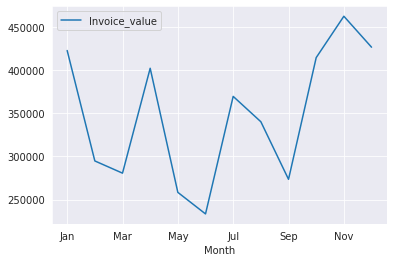

In [496]:
df3 =df3.sort_index()
df3.plot(x='Month', y= 'Invoice_value', kind ="line") # by below graph we can say by month by month revenue increases.

### 2.7 How number order varies and sales with different days?


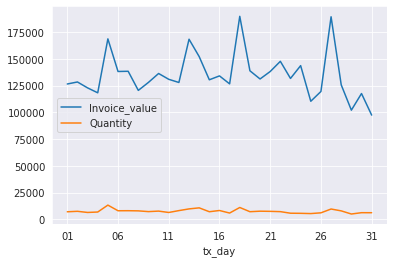

In [497]:
sales= pd.DataFrame(df_fin.groupby('tx_day').agg({"Invoice_value": sum , 'Quantity': sum})).reset_index()
sales.plot(x='tx_day', y= ['Invoice_value', 'Quantity'], kind ="line")

### 2.8 Calculate the revenue, marketing spend, percentage of makreting spend out revenue , tax, percentage of delivery charges by month

In [498]:
markt.head()

,Date,Offline_Spend,Online_Spend
0,1/1/2019,4500,2424.50
1,1/2/2019,4500,3480.36
2,1/3/2019,4500,1576.38
3,1/4/2019,4500,2928.55
4,1/5/2019,4500,4055.30


In [499]:
markt.Date = pd.to_datetime(markt.Date)
markt ['Month'] = markt.Date.dt.strftime("%b")

Marketing spend, Revenue, Percentage of makreting spend out revenue


In [500]:
Marketing_spend = markt.groupby('Month').agg({'Offline_Spend' : sum, 'Online_Spend' : sum})
Marketing_spend

,Offline_Spend,Online_Spend
Month,,
Apr,96000,61026.83
Aug,85500,57404.15
Dec,122000,76648.75
Feb,81300,55807.92
Jan,96600,58328.95
Jul,67500,52717.85
Jun,80500,53818.14
Mar,73500,48750.09
May,65500,52759.64


In [501]:
Monthly_Revenue.reset_index(inplace = True)
Revenue_Spend = pd.merge(Monthly_Revenue, Marketing_spend, left_on = 'tx_month', right_on= 'Month', how= "inner")
Revenue_Spend.rename(columns= {'Invoice_value': "revenue"}, inplace  =True)
Revenue_Spend['Total_Marketing_Spend'] = Revenue_Spend.Offline_Spend + Revenue_Spend.Online_Spend
Revenue_Spend['%of_marketing_spend_out_of_revenue']= (Revenue_Spend['Total_Marketing_Spend'] / Revenue_Spend["revenue"])*100

In [502]:
Revenue_Spend

,tx_year,tx_month,revenue,ActiveCustomers,MonthlyOrderCount,MonthlyOrderAverage,Offline_Spend,Online_Spend,Total_Marketing_Spend,%of_marketing_spend_out_of_revenue
0,2019,Apr,172006.02,224,25277,96.913667,96000,61026.83,157026.83,91.291473
1,2019,Aug,138939.68,300,27457,55.320870,85500,57404.15,142904.15,102.853375
2,2019,Dec,150221.36,236,12667,94.764340,122000,76648.75,198648.75,132.237353
3,2019,Feb,189654.00,109,16575,89.769610,81300,55807.92,137107.92,72.293714
4,2019,Jan,338937.89,215,20140,104.054137,96600,58328.95,154928.95,45.710130
5,2019,Jul,102414.11,236,22898,70.389014,67500,52717.85,120217.85,117.384069
6,2019,Jun,125570.81,259,21619,55.665492,80500,53818.14,134318.14,106.966054
7,2019,Mar,186905.55,208,20787,64.575251,73500,48750.09,122250.09,65.407416
8,2019,May,125731.55,200,18715,56.513959,65500,52759.64,118259.64,94.057251
9,2019,Nov,174840.15,188,15120,116.762361,93000,68144.96,161144.96,92.167022


In [503]:
df_fin.columns


Index(['CustomerID', 'Transaction_ID', 'Quantity', 'Avg_Price',
       'Delivery_Charges', 'Tenure_Months', 'GST', 'Discount_pct',
       'Product_Category_Android', 'Product_Category_Apparel',
       'Product_Category_Backpacks', 'Product_Category_Bags',
       'Product_Category_Bottles', 'Product_Category_Drinkware',
       'Product_Category_Fun', 'Product_Category_Gift Cards',
       'Product_Category_Google', 'Product_Category_Headgear',
       'Product_Category_Housewares', 'Product_Category_Lifestyle',
       'Product_Category_More Bags', 'Product_Category_Nest',
       'Product_Category_Nest-Canada', 'Product_Category_Nest-USA',
       'Product_Category_Notebooks & Journals', 'Product_Category_Office',
       'Product_Category_Waze', 'Coupon_Status_Not Used', 'Coupon_Status_Used',
       'Gender_M', 'Location_Chicago', 'Location_New Jersey',
       'Location_New York', 'Location_Washington DC', 'Product_SKU',
       'Product_Description', 'tx_Month', 'Month', 'Transaction_Date',

#### Tax by month


In [504]:
df['Invoice_value'] = df['Quantity']*df['Avg_Price']*1-df['Discount_pct']*1+df['GST']+df.Delivery_Charges


In [505]:
df.groupby(['Product_Category', 'GST']).Invoice_value.sum()


Product_Category      GST 
Accessories           0.10       89361.35
Android               0.10        3434.34
Apparel               0.18     6935709.64
Backpacks             0.10      141006.67
Bags                  0.18     2381670.08
Bottles               0.05       88264.34
Drinkware             0.18     3098130.15
Fun                   0.18       84628.04
Gift Cards            0.05      288350.09
Google                0.10      174543.42
Headgear              0.05      779510.01
Housewares            0.12       74612.49
Lifestyle             0.18      996173.14
More Bags             0.18       43535.98
Nest                  0.05     8244085.40
Nest-Canada           0.10     1148605.85
Nest-USA              0.10    40405153.75
Notebooks & Journals  0.05     1853893.69
Office                0.10     4207901.37
Waze                  0.18        8080.44
Name: Invoice_value, dtype: float64

#### Percentage of delivery charges by Month


In [506]:
df_fin.Delivery_Charges.sum()


556635.0700000001

In [507]:
(df_fin.groupby('tx_month').Delivery_Charges.sum()/df_fin.Delivery_Charges.sum())*100


tx_month
Apr     7.452233
Aug    10.976594
Dec     6.805534
Feb     8.841807
Jan    10.642937
Jul     8.753299
Jun     6.739349
Mar    10.922765
May     7.436860
Nov     5.804868
Oct     8.257094
Sep     7.366661
Name: Delivery_Charges, dtype: float64

### 2.9 How markrting spend is imapacting on revenues?


In [508]:
df4 = Revenue_Spend.iloc[:, [1,2,8]]
df4.sort_values(by= 'revenue')

,tx_month,revenue,Total_Marketing_Spend
11,Sep,98856.99,135514.54
5,Jul,102414.11,120217.85
6,Jun,125570.81,134318.14
8,May,125731.55,118259.64
1,Aug,138939.68,142904.15
2,Dec,150221.36,198648.75
0,Apr,172006.02,157026.83
9,Nov,174840.15,161144.96
10,Oct,179492.80,151224.65
7,Mar,186905.55,122250.09


In [509]:
sort_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df4.index = pd.CategoricalIndex(df4['tx_month'], categories= sort_order, ordered  = True)
print(df4)

         tx_month    revenue  Total_Marketing_Spend
tx_month                                           
Apr           Apr  172006.02              157026.83
Aug           Aug  138939.68              142904.15
Dec           Dec  150221.36              198648.75
Feb           Feb  189654.00              137107.92
Jan           Jan  338937.89              154928.95
Jul           Jul  102414.11              120217.85
Jun           Jun  125570.81              134318.14
Mar           Mar  186905.55              122250.09
May           May  125731.55              118259.64
Nov           Nov  174840.15              161144.96
Oct           Oct  179492.80              151224.65
Sep           Sep   98856.99              135514.54


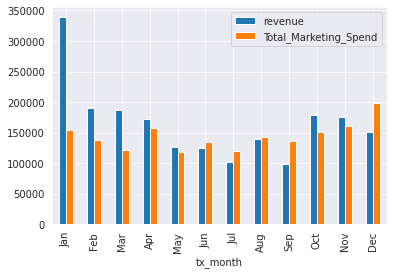

In [510]:
df4 = df4.sort_index()
df4.plot(x= 'tx_month', y= ['revenue', 'Total_Marketing_Spend'], kind= 'bar')

In [511]:
#So, in intial months revenues are more than marketing spend till JUNE, after revenue decrease and increases. 


As we can see by above dataframe, if we increase in marketing spend then revenue automatically increases.


### 2.10 which product was appeared in the transactions?


In [512]:
df.groupby("Product_Category").Invoice_value.sum().sort_values(ascending = False)


Product_Category
Nest-USA                40405153.75
Nest                     8244085.40
Apparel                  6935709.64
Office                   4207901.37
Drinkware                3098130.15
Bags                     2381670.08
Notebooks & Journals     1853893.69
Nest-Canada              1148605.85
Lifestyle                 996173.14
Headgear                  779510.01
Gift Cards                288350.09
Google                    174543.42
Backpacks                 141006.67
Accessories                89361.35
Bottles                    88264.34
Fun                        84628.04
Housewares                 74612.49
More Bags                  43535.98
Waze                        8080.44
Android                     3434.34
Name: Invoice_value, dtype: float64

The most Nest-USA product Category apperead most in tranasctions


### 2.11 Which product was purchased mostly based on the quantity?


In [513]:
df.groupby("Product_Category").Quantity.sum().sort_values(ascending = False)


Product_Category
Office                  1502511
Apparel                  551446
Drinkware                518517
Lifestyle                422977
Nest-USA                 364310
Bags                     259641
Notebooks & Journals     162452
Headgear                  60061
Nest                      48229
Housewares                42228
Bottles                   35530
Waze                      19448
Accessories               18649
Fun                       14178
Google                     9775
Nest-Canada                7973
Gift Cards                 3502
More Bags                  2448
Backpacks                  1921
Android                     765
Name: Quantity, dtype: int64

The office products purchased mostly based on quantity.


## 3 . Performing Customer Segmentation


### 3.1 Heuristic (Value Based, RFM) - Divide the customers into Premium, Gold, Silver, Standard customers and define strategy on the same.

#### Value based


In [514]:
# Value based segmentation (3 groups, 5 groups, 10 groups) based on the cut-offs
# Deciles creations (segments) - segmentation - 10 groups by taking cut-offs p10, p20, p30....p90
df_fin.columns

Index(['CustomerID', 'Transaction_ID', 'Quantity', 'Avg_Price',
       'Delivery_Charges', 'Tenure_Months', 'GST', 'Discount_pct',
       'Product_Category_Android', 'Product_Category_Apparel',
       'Product_Category_Backpacks', 'Product_Category_Bags',
       'Product_Category_Bottles', 'Product_Category_Drinkware',
       'Product_Category_Fun', 'Product_Category_Gift Cards',
       'Product_Category_Google', 'Product_Category_Headgear',
       'Product_Category_Housewares', 'Product_Category_Lifestyle',
       'Product_Category_More Bags', 'Product_Category_Nest',
       'Product_Category_Nest-Canada', 'Product_Category_Nest-USA',
       'Product_Category_Notebooks & Journals', 'Product_Category_Office',
       'Product_Category_Waze', 'Coupon_Status_Not Used', 'Coupon_Status_Used',
       'Gender_M', 'Location_Chicago', 'Location_New Jersey',
       'Location_New York', 'Location_Washington DC', 'Product_SKU',
       'Product_Description', 'tx_Month', 'Month', 'Transaction_Date',

In [515]:
print('Min Invoice Date:',df_fin.Transaction_Date.dt.date.min(),'max Invoice Date:',
       df_fin.Transaction_Date.dt.date.max())


Min Invoice Date: 2019-01-01 max Invoice Date: 2019-12-31


In [516]:
snapshot_date = df_fin['Transaction_Date'].max() + dt.timedelta(days=1)
snapshot_date
#The last day of purchase in total is 09 DEC, 2011. To calculate the day periods, 
#let's set one day after the last one,or 
#10 DEC as a snapshot_date. We will cound the diff days with snapshot_date.

Timestamp('2020-01-01 00:00:00')

In [517]:
# Calculate RFM metrics
rfm = df_fin.groupby(['CustomerID']).agg({'Transaction_Date': lambda x : (snapshot_date - x.max()).days,
                                      'Transaction_ID':'count','Invoice_value': 'sum'})
#Function Lambdea: it gives the number of days between hypothetical today and the last transaction

#Rename columns
rfm.rename(columns={'Transaction_Date':'Recency','Transaction_ID':'Frequency','Invoice_value':'MonetaryValue'}
           ,inplace= True)

#Final RFM values
rfm.reset_index(inplace=True)

In [518]:
rfm


,CustomerID,Recency,Frequency,MonetaryValue
0,12346,108,2,121.27
1,12347,60,60,12997.81
2,12348,74,23,1072.69
3,12350,18,17,980.11
4,12356,108,36,1005.30
...,...,...,...,...
1463,18259,271,7,753.80
1464,18260,88,40,2120.88
1465,18269,195,8,54.42
1466,18277,70,1,294.10


In [519]:
#df_fin.loc[df_fin.CustomerID == 12346]


In [520]:
rfm.MonetaryValue.quantile([0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90])


0.1     110.753
0.2     377.280
0.3     674.919
0.4    1031.730
0.5    1541.720
0.6    2096.490
0.7    2893.020
0.8    4274.586
0.9    6659.308
Name: MonetaryValue, dtype: float64

In [521]:
df_fin = pd.merge(df_fin, rfm, on= 'CustomerID', how= "inner")
df_fin['Deciles'] = pd.qcut(df_fin.MonetaryValue, 10, labels=False)
df_fin.head()

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Invoice_value,tx_month,tx_year,tx_day,First_tx_Date,customer_type,Recency,Frequency,MonetaryValue,Deciles
0,17850,16679,1,153.71,6.5,12,0.10,10,0,0,...,150.31,Jan,2019,01,2019-01-01,New,340,297,34783.15,9
1,17850,16680,1,153.71,6.5,12,0.10,10,0,0,...,150.31,Jan,2019,01,2019-01-01,New,340,297,34783.15,9
2,17850,16681,1,2.05,6.5,12,0.10,10,0,0,...,-1.35,Jan,2019,01,2019-01-01,New,340,297,34783.15,9
3,17850,16682,5,17.53,6.5,12,0.18,10,0,1,...,84.33,Jan,2019,01,2019-01-01,New,340,297,34783.15,9
4,17850,16682,1,16.50,6.5,12,0.18,10,0,0,...,13.18,Jan,2019,01,2019-01-01,New,340,297,34783.15,9


In [522]:
df_fin.Deciles.value_counts()


8    5393
6    5335
5    5316
1    5305
2    5301
3    5299
0    5298
7    5268
4    5263
9    5146
Name: Deciles, dtype: int64

In [523]:
df_fin.groupby('Deciles').agg(np.mean)['MonetaryValue']


Deciles
0      495.830081
1     1397.265761
2     2251.696457
3     3125.307311
4     4211.872814
5     5483.264428
6     7072.596853
7     9233.532994
8    14023.519835
9    43103.518467
Name: MonetaryValue, dtype: float64

In [524]:
df_fin.columns


Index(['CustomerID', 'Transaction_ID', 'Quantity', 'Avg_Price',
       'Delivery_Charges', 'Tenure_Months', 'GST', 'Discount_pct',
       'Product_Category_Android', 'Product_Category_Apparel',
       'Product_Category_Backpacks', 'Product_Category_Bags',
       'Product_Category_Bottles', 'Product_Category_Drinkware',
       'Product_Category_Fun', 'Product_Category_Gift Cards',
       'Product_Category_Google', 'Product_Category_Headgear',
       'Product_Category_Housewares', 'Product_Category_Lifestyle',
       'Product_Category_More Bags', 'Product_Category_Nest',
       'Product_Category_Nest-Canada', 'Product_Category_Nest-USA',
       'Product_Category_Notebooks & Journals', 'Product_Category_Office',
       'Product_Category_Waze', 'Coupon_Status_Not Used', 'Coupon_Status_Used',
       'Gender_M', 'Location_Chicago', 'Location_New Jersey',
       'Location_New York', 'Location_Washington DC', 'Product_SKU',
       'Product_Description', 'tx_Month', 'Month', 'Transaction_Date',

In [525]:
#profiling
# Key performace variable selection
col_kpi=['MonetaryValue','Recency','Frequency','Quantity',
         'GST']
profiling_output= df_fin.groupby(['Deciles']).apply(lambda x: x[col_kpi].mean()).T
profiling_output

Deciles,0,1,2,3,4,5,6,7,8,9
MonetaryValue,495.830081,1397.265761,2251.696457,3125.307311,4211.872814,5483.264428,7072.596853,9233.532994,14023.519835,43103.518467
Recency,160.170819,151.231480,137.051122,129.920174,118.047121,143.330512,113.556139,75.671412,77.818283,57.212204
Frequency,16.542846,26.733836,36.451424,46.744480,61.623979,72.650113,88.849672,118.481017,169.056740,450.011660
Quantity,3.023594,4.057304,4.038106,4.357992,4.641649,4.026524,4.821368,4.206150,5.209902,6.642052
GST,0.145987,0.140537,0.137846,0.136363,0.134739,0.135666,0.134319,0.135754,0.135672,0.137773


#### RFM Segmenttion


In [526]:
df_fin

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Invoice_value,tx_month,tx_year,tx_day,First_tx_Date,customer_type,Recency,Frequency,MonetaryValue,Deciles
0,17850,16679,1,153.71,6.50,12,0.10,10,0,0,...,150.31,Jan,2019,01,2019-01-01,New,340,297,34783.15,9
1,17850,16680,1,153.71,6.50,12,0.10,10,0,0,...,150.31,Jan,2019,01,2019-01-01,New,340,297,34783.15,9
2,17850,16681,1,2.05,6.50,12,0.10,10,0,0,...,-1.35,Jan,2019,01,2019-01-01,New,340,297,34783.15,9
3,17850,16682,5,17.53,6.50,12,0.18,10,0,1,...,84.33,Jan,2019,01,2019-01-01,New,340,297,34783.15,9
4,17850,16682,1,16.50,6.50,12,0.18,10,0,0,...,13.18,Jan,2019,01,2019-01-01,New,340,297,34783.15,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52919,14410,48493,1,121.30,6.50,45,0.10,30,0,0,...,97.90,Dec,2019,31,2019-12-31,New,1,8,921.72,0
52920,14410,48494,1,48.92,6.50,45,0.18,30,0,1,...,25.60,Dec,2019,31,2019-12-31,New,1,8,921.72,0
52921,14410,48495,1,151.88,6.50,45,0.10,30,0,0,...,128.48,Dec,2019,31,2019-12-31,New,1,8,921.72,0
52922,14600,48496,5,80.52,6.50,7,0.10,30,0,0,...,379.20,Dec,2019,31,2019-12-31,New,1,2,691.37,0


In [527]:
quantiles = df_fin[['Frequency','MonetaryValue','Recency' ]].quantile(q=[0.33,0.67])
quantiles

,Frequency,MonetaryValue,Recency
0.33,43.0,2901.86,48.0
0.67,93.0,7275.82,143.0


In [528]:
df_fin['r_seg'] = np.where(df_fin.Recency<=48, 'Active', np.where(df_fin.Recency<=143, 'At Risk', 'Churn'))
df_fin['f_seg'] = np.where(df_fin.Frequency<=42, 1, np.where(df_fin.Frequency<=93, 2, 3))
df_fin['m_seg'] = np.where(df_fin.MonetaryValue<=2882.40, 1, np.where(df_fin.MonetaryValue<=7275.82, 2, 3))
df_fin.head()

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,tx_day,First_tx_Date,customer_type,Recency,Frequency,MonetaryValue,Deciles,r_seg,f_seg,m_seg
0,17850,16679,1,153.71,6.5,12,0.10,10,0,0,...,01,2019-01-01,New,340,297,34783.15,9,Churn,3,3
1,17850,16680,1,153.71,6.5,12,0.10,10,0,0,...,01,2019-01-01,New,340,297,34783.15,9,Churn,3,3
2,17850,16681,1,2.05,6.5,12,0.10,10,0,0,...,01,2019-01-01,New,340,297,34783.15,9,Churn,3,3
3,17850,16682,5,17.53,6.5,12,0.18,10,0,1,...,01,2019-01-01,New,340,297,34783.15,9,Churn,3,3
4,17850,16682,1,16.50,6.5,12,0.18,10,0,0,...,01,2019-01-01,New,340,297,34783.15,9,Churn,3,3


In [529]:
df_fin['fm_seg'] = np.where(((df_fin.f_seg == 3) & (df_fin.m_seg ==3)) , 'Platinum',
                          np.where((((df_fin.f_seg == 3) & (df_fin.m_seg ==2)) | ((df_fin.f_seg == 2) & (df_fin.m_seg ==3))) , 'Gold',
                          np.where((((df_fin.f_seg == 1) & (df_fin.m_seg ==3)) | ((df_fin.f_seg == 3) & (df_fin.m_seg ==1)) | ((df_fin.f_seg == 2) & (df_fin.m_seg ==2))), 'Silver', 'Standard' )))
df_fin.head()

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,First_tx_Date,customer_type,Recency,Frequency,MonetaryValue,Deciles,r_seg,f_seg,m_seg,fm_seg
0,17850,16679,1,153.71,6.5,12,0.10,10,0,0,...,2019-01-01,New,340,297,34783.15,9,Churn,3,3,Platinum
1,17850,16680,1,153.71,6.5,12,0.10,10,0,0,...,2019-01-01,New,340,297,34783.15,9,Churn,3,3,Platinum
2,17850,16681,1,2.05,6.5,12,0.10,10,0,0,...,2019-01-01,New,340,297,34783.15,9,Churn,3,3,Platinum
3,17850,16682,5,17.53,6.5,12,0.18,10,0,1,...,2019-01-01,New,340,297,34783.15,9,Churn,3,3,Platinum
4,17850,16682,1,16.50,6.5,12,0.18,10,0,0,...,2019-01-01,New,340,297,34783.15,9,Churn,3,3,Platinum


In [530]:
df_fin[(df_fin.r_seg=='Active') & (df_fin.fm_seg == 'Platinum')]


,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,First_tx_Date,customer_type,Recency,Frequency,MonetaryValue,Deciles,r_seg,f_seg,m_seg,fm_seg
498,15311,16748,1,153.71,6.5,40,0.10,10,0,0,...,2019-01-02,New,13,587,68895.59,9,Active,3,3,Platinum
499,15311,16749,1,24.75,6.5,40,0.18,10,0,1,...,2019-01-02,New,13,587,68895.59,9,Active,3,3,Platinum
500,15311,16749,1,2.05,6.5,40,0.10,10,0,0,...,2019-01-02,New,13,587,68895.59,9,Active,3,3,Platinum
501,15311,16749,1,2.05,6.5,40,0.10,10,0,0,...,2019-01-02,New,13,587,68895.59,9,Active,3,3,Platinum
502,15311,16750,1,61.89,6.5,40,0.18,10,0,1,...,2019-01-02,New,13,587,68895.59,9,Active,3,3,Platinum
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52043,17337,47059,1,22.41,6.0,44,0.18,30,0,1,...,2019-12-14,Existing,17,260,30395.20,9,Active,3,3,Platinum
52044,17337,47059,1,22.41,6.0,44,0.18,30,0,1,...,2019-12-14,Existing,17,260,30395.20,9,Active,3,3,Platinum
52045,17337,47059,1,22.41,6.0,44,0.18,30,0,1,...,2019-12-14,Existing,17,260,30395.20,9,Active,3,3,Platinum
52046,17337,47059,1,22.41,6.0,44,0.18,30,0,1,...,2019-12-14,Existing,17,260,30395.20,9,Active,3,3,Platinum


In [531]:
profiling_output= df_fin.groupby(['r_seg', 'fm_seg']).apply(lambda x: x[col_kpi].mean()).T
profiling_output

r_seg               Active                                          \
fm_seg                Gold      Platinum       Silver     Standard   
MonetaryValue  9556.529982  25098.765668  5337.021110  2150.893434   
Recency          27.945165     20.529965    25.182724    24.619037   
Frequency        85.366745    288.209629    64.943522    26.813340   
Quantity          8.687500      4.659855     3.394795     3.657017   
GST               0.130342      0.136424     0.131586     0.127974   

r_seg              At Risk                                          \
fm_seg                Gold      Platinum       Silver     Standard   
MonetaryValue  7311.383746  21720.388128  4733.746912  1930.402118   
Recency          98.854846     88.582909    91.898778    98.453482   
Frequency        96.774011    249.014419    65.079218    32.473376   
Quantity          4.245980      4.672180     3.864059     4.100351   
GST               0.136006      0.138707     0.136995     0.140432   

r_seg                Churn                                          
fm_seg                Gold      Platinum       Silver     Standard  
MonetaryValue  7218.231760  14540.790872  4843.836501  1698.527875  
Recency         239.660550    223.148743   240.529062   231.899638  
Frequency        93.764908    170.660781    65.974828    27.319498  
Quantity          6.240252      4.731407     4.988558     4.354513  
GST               0.140390      0.139508     0.139048     0.142333

### Scientific (Using K-Means) & Understand the profiles. Define strategy for each segment.


#### Kmeans Segmentation


In [532]:
df_fin1.columns


Index(['CustomerID', 'Transaction_ID', 'Quantity', 'Avg_Price',
       'Delivery_Charges', 'Tenure_Months', 'GST', 'Discount_pct',
       'Product_Category_Android', 'Product_Category_Apparel',
       'Product_Category_Backpacks', 'Product_Category_Bags',
       'Product_Category_Bottles', 'Product_Category_Drinkware',
       'Product_Category_Fun', 'Product_Category_Gift Cards',
       'Product_Category_Google', 'Product_Category_Headgear',
       'Product_Category_Housewares', 'Product_Category_Lifestyle',
       'Product_Category_More Bags', 'Product_Category_Nest',
       'Product_Category_Nest-Canada', 'Product_Category_Nest-USA',
       'Product_Category_Notebooks & Journals', 'Product_Category_Office',
       'Product_Category_Waze', 'Coupon_Status_Not Used', 'Coupon_Status_Used',
       'Gender_M', 'Location_Chicago', 'Location_New Jersey',
       'Location_New York', 'Location_Washington DC', 'Product_SKU',
       'Product_Description', 'tx_Month', 'Month', 'Transaction_Date',

In [533]:
df_fin1.head(2)


,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Location_Washington DC,Product_SKU,Product_Description,tx_Month,Month,Transaction_Date,Invoice_value,tx_month,tx_year,tx_day
0,17850,16679,1,153.71,6.5,12,0.1,10,0,0,...,0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,Jan,2019-01-01,150.31,Jan,2019,01
17,17850,16680,1,153.71,6.5,12,0.1,10,0,0,...,0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,Jan,2019-01-01,150.31,Jan,2019,01


In [534]:
df_fin1.dtypes

CustomerID                                        int64
Transaction_ID                                    int64
Quantity                                          int64
Avg_Price                                       float64
Delivery_Charges                                float64
Tenure_Months                                     int64
GST                                             float64
Discount_pct                                      int64
Product_Category_Android                          uint8
Product_Category_Apparel                          uint8
Product_Category_Backpacks                        uint8
Product_Category_Bags                             uint8
Product_Category_Bottles                          uint8
Product_Category_Drinkware                        uint8
Product_Category_Fun                              uint8
Product_Category_Gift Cards                       uint8
Product_Category_Google                           uint8
Product_Category_Headgear                       

In [535]:
df_fin1.drop(['Product_SKU', 'Product_Description',  'Month','tx_month','tx_year','tx_day','Transaction_Date'], axis =1, inplace = True)


In [536]:
df_fin1 # Drop the variables having high cardinility 


,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Product_Category_Waze,Coupon_Status_Not Used,Coupon_Status_Used,Gender_M,Location_Chicago,Location_New Jersey,Location_New York,Location_Washington DC,tx_Month,Invoice_value
0,17850,16679,1,153.71,6.50,12,0.10,10,0,0,...,0,0,1,1,1,0,0,0,Jan,150.31
17,17850,16680,1,153.71,6.50,12,0.10,10,0,0,...,0,0,1,1,1,0,0,0,Jan,150.31
34,17850,16681,1,2.05,6.50,12,0.10,10,0,0,...,0,0,1,1,1,0,0,0,Jan,-1.35
51,17850,16682,5,17.53,6.50,12,0.18,10,0,1,...,0,1,0,1,1,0,0,0,Jan,84.33
68,17850,16682,1,16.50,6.50,12,0.18,10,0,0,...,0,0,1,1,1,0,0,0,Jan,13.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899623,14410,48493,1,121.30,6.50,45,0.10,30,0,0,...,0,0,0,0,0,0,1,0,Dec,97.90
899640,14410,48494,1,48.92,6.50,45,0.18,30,0,1,...,0,0,1,0,0,0,1,0,Dec,25.60
899657,14410,48495,1,151.88,6.50,45,0.10,30,0,0,...,0,0,1,0,0,0,1,0,Dec,128.48
899674,14600,48496,5,80.52,6.50,7,0.10,30,0,0,...,0,0,0,0,0,0,0,0,Dec,379.20


In [537]:
df_fin1.columns


Index(['CustomerID', 'Transaction_ID', 'Quantity', 'Avg_Price',
       'Delivery_Charges', 'Tenure_Months', 'GST', 'Discount_pct',
       'Product_Category_Android', 'Product_Category_Apparel',
       'Product_Category_Backpacks', 'Product_Category_Bags',
       'Product_Category_Bottles', 'Product_Category_Drinkware',
       'Product_Category_Fun', 'Product_Category_Gift Cards',
       'Product_Category_Google', 'Product_Category_Headgear',
       'Product_Category_Housewares', 'Product_Category_Lifestyle',
       'Product_Category_More Bags', 'Product_Category_Nest',
       'Product_Category_Nest-Canada', 'Product_Category_Nest-USA',
       'Product_Category_Notebooks & Journals', 'Product_Category_Office',
       'Product_Category_Waze', 'Coupon_Status_Not Used', 'Coupon_Status_Used',
       'Gender_M', 'Location_Chicago', 'Location_New Jersey',
       'Location_New York', 'Location_Washington DC', 'tx_Month',
       'Invoice_value'],
      dtype='object')

In [538]:
df_fin1.dtypes


CustomerID                                 int64
Transaction_ID                             int64
Quantity                                   int64
Avg_Price                                float64
Delivery_Charges                         float64
Tenure_Months                              int64
GST                                      float64
Discount_pct                               int64
Product_Category_Android                   uint8
Product_Category_Apparel                   uint8
Product_Category_Backpacks                 uint8
Product_Category_Bags                      uint8
Product_Category_Bottles                   uint8
Product_Category_Drinkware                 uint8
Product_Category_Fun                       uint8
Product_Category_Gift Cards                uint8
Product_Category_Google                    uint8
Product_Category_Headgear                  uint8
Product_Category_Housewares                uint8
Product_Category_Lifestyle                 uint8
Product_Category_Mor

In [539]:
df_fin1.drop('tx_Month',axis=1,inplace=True)

sc = StandardScaler()
std_model = sc.fit(df_fin1)
std_model.transform(df_fin1)

array([[ 1.41705885, -1.81888963, -0.17397272, ..., -0.5173107 ,
        -0.23330449,  0.42810901],
       [ 1.41705885, -1.818774  , -0.17397272, ..., -0.5173107 ,
        -0.23330449,  0.42810901],
       [ 1.41705885, -1.81865838, -0.17397272, ..., -0.5173107 ,
        -0.23330449, -0.48195104],
       ...,
       [-0.53025132,  1.85986148, -0.17397272, ...,  1.93307428,
        -0.23330449,  0.29711461],
       [-0.4226964 ,  1.85997711,  0.02498751, ..., -0.5173107 ,
        -0.23330449,  1.80160001],
       [-0.4226964 ,  1.86009273, -0.02475255, ..., -0.5173107 ,
        -0.23330449,  1.39937579]])

In [540]:
df_fin1_scaled = pd.DataFrame(std_model.transform(df_fin1), columns = df_fin1.columns)
df_fin1_scaled

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Product_Category_Office,Product_Category_Waze,Coupon_Status_Not Used,Coupon_Status_Used,Gender_M,Location_Chicago,Location_New Jersey,Location_New York,Location_Washington DC,Invoice_value
0,1.417059,-1.818890,-0.173973,1.585350,-0.206292,-1.048214,-0.817509,-1.223515,-0.028516,-0.721728,...,-0.374611,-0.102852,-0.424910,1.398566,1.287333,1.370925,-0.304954,-0.517311,-0.233304,0.428109
1,1.417059,-1.818774,-0.173973,1.585350,-0.206292,-1.048214,-0.817509,-1.223515,-0.028516,-0.721728,...,-0.374611,-0.102852,-0.424910,1.398566,1.287333,1.370925,-0.304954,-0.517311,-0.233304,0.428109
2,1.417059,-1.818658,-0.173973,-0.784105,-0.206292,-1.048214,-0.817509,-1.223515,-0.028516,-0.721728,...,2.669439,-0.102852,-0.424910,1.398566,1.287333,1.370925,-0.304954,-0.517311,-0.233304,-0.481951
3,1.417059,-1.818543,0.024988,-0.542254,-0.206292,-1.048214,0.928288,-1.223515,-0.028516,1.385563,...,-0.374611,-0.102852,2.353438,-0.715018,1.287333,1.370925,-0.304954,-0.517311,-0.233304,0.032185
4,1.417059,-1.818543,-0.173973,-0.558346,-0.206292,-1.048214,0.928288,-1.223515,-0.028516,-0.721728,...,-0.374611,-0.102852,-0.424910,1.398566,1.287333,1.370925,-0.304954,-0.517311,-0.233304,-0.394761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52919,-0.530251,1.859630,-0.173973,1.078993,-0.206292,1.400192,-0.817509,1.237418,-0.028516,-0.721728,...,-0.374611,-0.102852,-0.424910,-0.715018,-0.776799,-0.729435,-0.304954,1.933074,-0.233304,0.113614
52920,-0.530251,1.859746,-0.173973,-0.051833,-0.206292,1.400192,0.928288,1.237418,-0.028516,1.385563,...,-0.374611,-0.102852,-0.424910,1.398566,-0.776799,-0.729435,-0.304954,1.933074,-0.233304,-0.320233
52921,-0.530251,1.859861,-0.173973,1.556759,-0.206292,1.400192,-0.817509,1.237418,-0.028516,-0.721728,...,-0.374611,-0.102852,-0.424910,1.398566,-0.776799,-0.729435,-0.304954,1.933074,-0.233304,0.297115
52922,-0.422696,1.859977,0.024988,0.441868,-0.206292,-1.419185,-0.817509,1.237418,-0.028516,-0.721728,...,-0.374611,-0.102852,-0.424910,-0.715018,-0.776799,-0.729435,-0.304954,-0.517311,-0.233304,1.801600


In [541]:
#Reduceing the variables for segmentation - 
#VIF
#Correlation metrics
#PCA

In [542]:
pca_model = PCA(n_components=16)
pca_model = pca_model.fit(df_fin1_scaled)
pca_model.explained_variance_  # Eigen values

array([3.07708816, 1.75840441, 1.44461531, 1.42864337, 1.36503203,
       1.30491475, 1.16678661, 1.15920956, 1.13084452, 1.07518026,
       1.05789579, 1.0397    , 1.03893395, 1.02136484, 1.01250237,
       1.00874685])

In [543]:
pca_model.explained_variance_ratio_

array([0.08791514, 0.05023918, 0.04127394, 0.04081761, 0.03900018,
       0.03728257, 0.03333613, 0.03311965, 0.03230923, 0.03071886,
       0.03022502, 0.02970515, 0.02968327, 0.0291813 , 0.02892809,
       0.02882079])

In [544]:

np.cumsum(pca_model.explained_variance_ratio_)

array([0.08791514, 0.13815432, 0.17942826, 0.22024587, 0.25924605,
       0.29652863, 0.32986476, 0.3629844 , 0.39529364, 0.42601249,
       0.45623752, 0.48594267, 0.51562593, 0.54480724, 0.57373533,
       0.60255612])

In [545]:
#number of compoents = 9
pca_model = PCA(n_components=9)

pca_model = pca_model.fit(df_fin1_scaled)

In [546]:
pca_model.explained_variance_


array([3.07706254, 1.75757737, 1.43946165, 1.41251694, 1.36010645,
       1.27692479, 1.15443862, 1.12104324, 1.09359555])

In [547]:
pca_model.explained_variance_ratio_


array([0.08791441, 0.05021555, 0.0411267 , 0.04035686, 0.03885945,
       0.03648288, 0.03298334, 0.0320292 , 0.031245  ])

In [548]:
sum(pca_model.explained_variance_ratio_)


0.3912133836371196

In [549]:
PCs = pd.DataFrame(pca_model.transform(df_fin1_scaled), columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9' ])
PCs   #Pc's can be used for segmentaiton input

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,2.051921,0.018119,1.356759,-0.697215,-2.833186,-1.177753,0.357725,-0.425635,-0.043756
1,2.051932,0.018092,1.356728,-0.697182,-2.833141,-1.177763,0.357713,-0.425640,-0.043750
2,-0.312220,1.938341,-1.486158,-1.098157,-2.455836,-1.170286,0.496664,-0.801569,-0.055960
3,-1.637688,0.108687,1.037712,0.378892,-1.783170,2.048318,1.321477,-0.708515,0.105746
4,-1.352322,0.762494,1.447331,0.346308,-2.165965,-1.272253,-0.646087,-1.722541,0.876119
...,...,...,...,...,...,...,...,...,...
52919,2.100373,-1.238486,-0.084006,-0.705712,1.409187,0.423177,-0.862433,0.077209,0.733860
52920,-1.159476,-1.542404,-0.185832,-0.358160,2.336414,-1.095906,0.160333,-0.208842,1.010313
52921,2.379439,-1.321279,0.099258,-0.849598,1.435814,-1.045957,-0.800834,-0.026246,0.819411
52922,2.348752,-0.431713,0.316098,0.627788,0.894251,-0.054609,-0.381921,0.812985,0.415513


In [550]:
#Variable reduction

Loadings =  pd.DataFrame((pca_model.components_.T * np.sqrt(pca_model.explained_variance_)).T,columns=df_fin1.columns).T

Loadings.columns= ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9']

Loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
CustomerID,-0.006964,0.014107,0.103120,-0.265093,-0.111579,0.062124,-0.009869,-0.348535,-0.139555
Transaction_ID,0.167802,-0.311019,-0.324469,0.337947,0.455349,-0.091355,-0.115004,-0.041546,0.051885
Quantity,0.079724,0.678870,0.236877,0.301190,0.256007,-0.068745,0.096992,-0.027478,-0.017543
Avg_Price,0.850969,-0.342603,0.224802,0.040699,0.005628,-0.001319,-0.011083,-0.023345,0.020947
Delivery_Charges,-0.049806,0.497322,0.147187,0.106577,0.167025,0.037116,0.068225,0.042489,0.060309
Tenure_Months,0.004042,-0.033569,-0.040498,0.137718,-0.017961,0.079191,0.044992,-0.179976,-0.166669
GST,-0.872939,-0.167021,0.383637,0.178882,0.061423,-0.023329,-0.107987,-0.031269,0.004175
Discount_pct,0.032266,-0.213431,-0.278136,0.225556,0.271511,0.034432,-0.105034,-0.086011,-0.058752
Product_Category_Android,0.000099,0.003248,-0.066186,-0.005636,-0.077774,-0.012118,0.015146,0.083448,-0.100988
Product_Category_Apparel,-0.646368,-0.367359,0.184569,0.082051,0.176445,0.001776,0.553563,0.050323,0.099813


In [551]:
Loadings.to_csv('loadings1.csv')


In [552]:
#PCA can be used for any type of business problem (regressin, classificaiton, segmentation)
selected_vars = ['Invoice_value',
'Avg_Price',
'Location_Chicago',
'Coupon_Status_Used',
'Discount_pct',
'Location_Washington DC',
'Location_New Jersey',
'CustomerID',
'Tenure_Months',
]

In [553]:
final_input_segmentation = df_fin1_scaled[selected_vars]   #variable reduction
final_input_segmentation   #These variables can be used for segmentaiton input

,Invoice_value,Avg_Price,Location_Chicago,Coupon_Status_Used,Discount_pct,Location_Washington DC,Location_New Jersey,CustomerID,Tenure_Months
0,0.428109,1.585350,1.370925,1.398566,-1.223515,-0.233304,-0.304954,1.417059,-1.048214
1,0.428109,1.585350,1.370925,1.398566,-1.223515,-0.233304,-0.304954,1.417059,-1.048214
2,-0.481951,-0.784105,1.370925,1.398566,-1.223515,-0.233304,-0.304954,1.417059,-1.048214
3,0.032185,-0.542254,1.370925,-0.715018,-1.223515,-0.233304,-0.304954,1.417059,-1.048214
4,-0.394761,-0.558346,1.370925,1.398566,-1.223515,-0.233304,-0.304954,1.417059,-1.048214
...,...,...,...,...,...,...,...,...,...
52919,0.113614,1.078993,-0.729435,-0.715018,1.237418,-0.233304,-0.304954,-0.530251,1.400192
52920,-0.320233,-0.051833,-0.729435,1.398566,1.237418,-0.233304,-0.304954,-0.530251,1.400192
52921,0.297115,1.556759,-0.729435,1.398566,1.237418,-0.233304,-0.304954,-0.530251,1.400192
52922,1.801600,0.441868,-0.729435,-0.715018,1.237418,-0.233304,-0.304954,-0.422696,-1.419185


In [554]:
#Segmentation
km_3 = KMeans(n_clusters=3, random_state=123)
km_3 = km_3.fit(final_input_segmentation)

In [555]:
km_3.labels_


array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [556]:
km_3.cluster_centers_


array([[-2.52776250e-03, -1.57714832e-03, -7.29434736e-01,
         7.58250769e-06, -1.68748019e-02, -2.33304490e-01,
         2.02382287e-01, -8.95653058e-03, -1.01634942e-02],
       [-1.07108461e-03, -5.07557972e-03,  1.37092457e+00,
        -2.17141758e-04,  4.59141927e-02, -2.33304490e-01,
        -3.04953833e-01, -8.58259799e-03,  9.35481414e-03],
       [ 3.66397202e-02,  5.25114925e-02, -7.29434736e-01,
         1.37256617e-03, -1.12401780e-01,  4.28624413e+00,
        -3.04953833e-01,  1.62032687e-01,  5.54098068e-02]])

In [557]:
#MEtrics for segmentation output is good or not
km_3.inertia_  #clsuter errors

367018.4538123124

In [558]:
silhouette_score(final_input_segmentation, km_3.labels_)


0.17032060890791592

In [559]:
#Segment distribution
dd = pd.Series(km_3.labels_)
dd.value_counts()/sum(dd.value_counts())

0    0.601088
1    0.347290
2    0.051621
dtype: float64

In [560]:
km_4 = KMeans(n_clusters=4, random_state=123).fit(final_input_segmentation)
km_5 = KMeans(n_clusters=5, random_state=123).fit(final_input_segmentation)
km_6 = KMeans(n_clusters=6, random_state=123).fit(final_input_segmentation)
km_7 = KMeans(n_clusters=7, random_state=123).fit(final_input_segmentation)
km_8 = KMeans(n_clusters=8, random_state=123).fit(final_input_segmentation)

In [561]:
df_fin1['cluster_3'] = km_3.labels_
df_fin1['cluster_4'] = km_4.labels_
df_fin1['cluster_5'] = km_5.labels_
df_fin1['cluster_6'] = km_6.labels_
df_fin1['cluster_7'] = km_7.labels_
df_fin1['cluster_8'] = km_8.labels_

In [562]:
df_fin1.head()


,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Location_New Jersey,Location_New York,Location_Washington DC,Invoice_value,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,17850,16679,1,153.71,6.5,12,0.10,10,0,0,...,0,0,0,150.31,1,0,4,1,3,6
17,17850,16680,1,153.71,6.5,12,0.10,10,0,0,...,0,0,0,150.31,1,0,4,1,3,6
34,17850,16681,1,2.05,6.5,12,0.10,10,0,0,...,0,0,0,-1.35,1,0,1,3,3,1
51,17850,16682,5,17.53,6.5,12,0.18,10,0,1,...,0,0,0,84.33,1,0,1,2,3,0
68,17850,16682,1,16.50,6.5,12,0.18,10,0,0,...,0,0,0,13.18,1,0,1,3,3,1


In [563]:
silhouette_score(final_input_segmentation, km_3.labels_)


0.17032060890791592

In [564]:
# calculate SC for K=3 through K=9
k_range = range(3, 9)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=123)
    km.fit(final_input_segmentation)
    scores.append(silhouette_score(final_input_segmentation, km.labels_))


In [565]:
scores


[0.17032060890791592,
 0.15143696109638144,
 0.1909395272599108,
 0.1872997522379329,
 0.19675913142508378,
 0.16080292321635253]

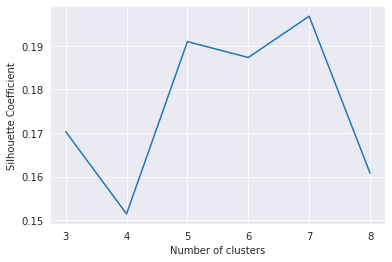

In [566]:
# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

In [567]:
#based on sc score, the solution K=4, the second solution can be k=8
df_fin1.cluster_3.value_counts()/sum(df_fin1.cluster_3.value_counts())

0    0.601088
1    0.347290
2    0.051621
Name: cluster_3, dtype: float64

In [568]:
sum(df_fin1.cluster_5.value_counts())


52924

In [569]:
df_fin1.cluster_4.value_counts()/sum(df_fin1.cluster_3.value_counts())


1    0.464572
0    0.398723
3    0.085084
2    0.051621
Name: cluster_4, dtype: float64

In [570]:
df_fin1.cluster_5.value_counts()/sum(df_fin1.cluster_3.value_counts())


0    0.363748
1    0.274979
4    0.224813
2    0.084858
3    0.051602
Name: cluster_5, dtype: float64

In [571]:
#Profiling
size=pd.concat([pd.Series(df_fin1.cluster_3.size), pd.Series.sort_index(df_fin1.cluster_3.value_counts()), pd.Series.sort_index(df_fin1.cluster_4.value_counts()),
           pd.Series.sort_index(df_fin1.cluster_5.value_counts()), pd.Series.sort_index(df_fin1.cluster_6.value_counts()),
           pd.Series.sort_index(df_fin1.cluster_7.value_counts()), pd.Series.sort_index(df_fin1.cluster_8.value_counts())])

In [572]:
size

0    52924
0    31812
1    18380
2     2732
0    21102
1    24587
2     2732
3     4503
0    19251
1    14553
2     4491
3     2731
4    11898
0     4448
1     9949
2    10012
3    12749
4    13035
5     2731
0     2730
1    12997
2     7669
3     6983
4     4447
5    10321
6     7777
0    10017
1    12749
2     7144
3     2730
4     4448
5     6988
6     8810
7       38
dtype: int64

In [573]:
Seg_size=pd.DataFrame(size, columns=['Seg_size'])
Seg_Pct = pd.DataFrame(size/df_fin1.cluster_3.size, columns=['Seg_Pct'])

In [574]:
Seg_Pct.T

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
Seg_Pct,1.0,0.601088,0.34729,0.051621,0.398723,0.464572,0.051621,0.085084,0.363748,0.274979,...,0.195015,0.146947,0.189271,0.240893,0.134986,0.051583,0.084045,0.132038,0.166465,0.000718


In [575]:
df_fin1.apply(np.mean).T


CustomerID                               15346.709810
Transaction_ID                           32409.825675
Quantity                                     4.497638
Avg_Price                                   52.237646
Delivery_Charges                            10.517630
Tenure_Months                               26.127995
GST                                          0.137462
Discount_pct                                19.943504
Product_Category_Android                     0.000812
Product_Category_Apparel                     0.342491
Product_Category_Backpacks                   0.001682
Product_Category_Bags                        0.035560
Product_Category_Bottles                     0.005064
Product_Category_Drinkware                   0.065811
Product_Category_Fun                         0.003023
Product_Category_Gift Cards                  0.003004
Product_Category_Google                      0.001984
Product_Category_Headgear                    0.014568
Product_Category_Housewares 

In [576]:
df_fin1.groupby('cluster_4').apply(np.mean).T


cluster_4,0,1,2,3
CustomerID,16367.114492,14479.767804,15632.946925,15124.840773
Transaction_ID,31475.070989,33202.928092,31475.301611,33026.815234
Quantity,4.108900,4.732054,4.503294,5.035976
Avg_Price,44.415754,58.410969,55.598712,53.146298
Delivery_Charges,10.587155,10.664289,10.344374,9.496165
Tenure_Months,17.242062,33.698459,26.874817,25.980457
GST,0.140814,0.134428,0.137053,0.138570
Discount_pct,18.984930,20.814251,19.030015,20.235399
Product_Category_Android,0.000616,0.001017,0.000366,0.000888
Product_Category_Apparel,0.364420,0.319722,0.346999,0.361315


In [577]:
# Mean value gives a good indication of the distribution of data. So we are finding mean value for each variable for each cluster
Profling_output = pd.concat([df_fin1.apply(lambda x: x.mean()).T, df_fin1.groupby('cluster_3').apply(lambda x: x.mean()).T, df_fin1.groupby('cluster_4').apply(lambda x: x.mean()).T,
          df_fin1.groupby('cluster_5').apply(lambda x: x.mean()).T, df_fin1.groupby('cluster_6').apply(lambda x: x.mean()).T,
          df_fin1.groupby('cluster_7').apply(lambda x: x.mean()).T, df_fin1.groupby('cluster_8').apply(lambda x: x.mean()).T], axis=1)

Profling_output

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
CustomerID,15346.709810,15330.887747,15331.548313,15632.946925,16367.114492,14479.767804,15632.946925,15124.840773,15387.586359,15315.568405,...,14251.219649,15306.664524,15317.945992,15370.095380,16891.536254,15633.153480,15124.547437,13807.016171,15340.612486,14636.921053
Transaction_ID,32409.825675,32374.751886,32609.438683,31475.301611,31475.070989,33202.928092,31475.301611,33026.815234,31787.028934,32352.759981,...,33093.455382,33831.024174,32237.448837,32016.203859,31235.257839,31483.434432,32911.047662,32844.785346,33828.534506,29709.447368
Quantity,4.497638,4.456211,4.568498,4.503294,4.108900,4.732054,4.503294,5.035976,4.478105,4.317117,...,3.947292,5.824482,4.259060,4.255785,4.575588,4.140293,4.467176,4.457642,3.858570,318.631579
Avg_Price,52.237646,52.136699,51.912777,55.598712,44.415754,58.410969,55.598712,53.146298,16.513818,26.602418,...,41.760412,150.789137,29.974007,29.256143,25.910281,55.635421,49.895661,25.751583,153.444662,17.521579
Delivery_Charges,10.517630,10.538413,10.507412,10.344374,10.587155,10.664289,10.344374,9.496165,11.229813,10.904993,...,10.206376,9.639446,10.838051,10.915160,10.942298,10.347190,9.524478,11.687952,8.721721,42.491316
Tenure_Months,26.127995,25.991010,26.254081,26.874817,17.242062,33.698459,26.874817,25.980457,25.868163,26.348450,...,31.422924,26.363636,26.351802,26.098518,23.487822,26.873260,25.968525,28.265455,26.186266,31.921053
GST,0.137462,0.137425,0.137587,0.137053,0.140814,0.134428,0.137053,0.138570,0.154841,0.148618,...,0.141911,0.093858,0.146587,0.147088,0.149495,0.137051,0.139573,0.147736,0.094368,0.124211
Discount_pct,19.943504,19.806362,20.316649,19.030015,18.984930,20.814251,19.030015,20.235399,19.640019,20.663781,...,20.799341,20.091295,20.302486,19.897247,19.862822,19.029304,20.229317,19.471952,20.195233,16.578947
Product_Category_Android,0.000812,0.000754,0.000979,0.000366,0.000616,0.001017,0.000366,0.000888,0.001039,0.001237,...,0.001163,0.000000,0.001497,0.000706,0.000980,0.000366,0.000899,0.001002,0.000000,0.000000
Product_Category_Apparel,0.342491,0.346410,0.335038,0.346999,0.364420,0.319722,0.346999,0.361315,0.483663,0.420257,...,0.367600,0.011187,0.402915,0.414072,0.443869,0.347253,0.365782,0.427304,0.007946,0.236842


In [578]:
Profling_output_final=pd.concat([Seg_size.T, Seg_Pct.T, Profling_output], axis=0)
Profling_output_final

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
Seg_size,52924.000000,31812.000000,18380.000000,2732.000000,21102.000000,24587.000000,2732.000000,4503.000000,19251.000000,14553.000000,...,10321.000000,7777.000000,10017.000000,12749.000000,7144.000000,2730.000000,4448.000000,6988.000000,8810.000000,38.000000
Seg_Pct,1.000000,0.601088,0.347290,0.051621,0.398723,0.464572,0.051621,0.085084,0.363748,0.274979,...,0.195015,0.146947,0.189271,0.240893,0.134986,0.051583,0.084045,0.132038,0.166465,0.000718
CustomerID,15346.709810,15330.887747,15331.548313,15632.946925,16367.114492,14479.767804,15632.946925,15124.840773,15387.586359,15315.568405,...,14251.219649,15306.664524,15317.945992,15370.095380,16891.536254,15633.153480,15124.547437,13807.016171,15340.612486,14636.921053
Transaction_ID,32409.825675,32374.751886,32609.438683,31475.301611,31475.070989,33202.928092,31475.301611,33026.815234,31787.028934,32352.759981,...,33093.455382,33831.024174,32237.448837,32016.203859,31235.257839,31483.434432,32911.047662,32844.785346,33828.534506,29709.447368
Quantity,4.497638,4.456211,4.568498,4.503294,4.108900,4.732054,4.503294,5.035976,4.478105,4.317117,...,3.947292,5.824482,4.259060,4.255785,4.575588,4.140293,4.467176,4.457642,3.858570,318.631579
Avg_Price,52.237646,52.136699,51.912777,55.598712,44.415754,58.410969,55.598712,53.146298,16.513818,26.602418,...,41.760412,150.789137,29.974007,29.256143,25.910281,55.635421,49.895661,25.751583,153.444662,17.521579
Delivery_Charges,10.517630,10.538413,10.507412,10.344374,10.587155,10.664289,10.344374,9.496165,11.229813,10.904993,...,10.206376,9.639446,10.838051,10.915160,10.942298,10.347190,9.524478,11.687952,8.721721,42.491316
Tenure_Months,26.127995,25.991010,26.254081,26.874817,17.242062,33.698459,26.874817,25.980457,25.868163,26.348450,...,31.422924,26.363636,26.351802,26.098518,23.487822,26.873260,25.968525,28.265455,26.186266,31.921053
GST,0.137462,0.137425,0.137587,0.137053,0.140814,0.134428,0.137053,0.138570,0.154841,0.148618,...,0.141911,0.093858,0.146587,0.147088,0.149495,0.137051,0.139573,0.147736,0.094368,0.124211
Discount_pct,19.943504,19.806362,20.316649,19.030015,18.984930,20.814251,19.030015,20.235399,19.640019,20.663781,...,20.799341,20.091295,20.302486,19.897247,19.862822,19.029304,20.229317,19.471952,20.195233,16.578947


In [579]:
#Profling_output_final.columns = ['Seg_' + str(i) for i in Profling_output_final.columns]
Profling_output_final.columns = ['Overall', 'KM3_1', 'KM3_2', 'KM3_3',
                                'KM4_1', 'KM4_2', 'KM4_3', 'KM4_4',
                                'KM5_1', 'KM5_2', 'KM5_3', 'KM5_4', 'KM5_5',
                                'KM6_1', 'KM6_2', 'KM6_3', 'KM6_4', 'KM6_5','KM6_6',
                                'KM7_1', 'KM7_2', 'KM7_3', 'KM7_4', 'KM7_5','KM7_6','KM7_7',
                                'KM8_1', 'KM8_2', 'KM8_3', 'KM8_4', 'KM8_5','KM8_6','KM8_7','KM8_8',]
Profling_output_final

,Overall,KM3_1,KM3_2,KM3_3,KM4_1,KM4_2,KM4_3,KM4_4,KM5_1,KM5_2,...,KM7_6,KM7_7,KM8_1,KM8_2,KM8_3,KM8_4,KM8_5,KM8_6,KM8_7,KM8_8
Seg_size,52924.000000,31812.000000,18380.000000,2732.000000,21102.000000,24587.000000,2732.000000,4503.000000,19251.000000,14553.000000,...,10321.000000,7777.000000,10017.000000,12749.000000,7144.000000,2730.000000,4448.000000,6988.000000,8810.000000,38.000000
Seg_Pct,1.000000,0.601088,0.347290,0.051621,0.398723,0.464572,0.051621,0.085084,0.363748,0.274979,...,0.195015,0.146947,0.189271,0.240893,0.134986,0.051583,0.084045,0.132038,0.166465,0.000718
CustomerID,15346.709810,15330.887747,15331.548313,15632.946925,16367.114492,14479.767804,15632.946925,15124.840773,15387.586359,15315.568405,...,14251.219649,15306.664524,15317.945992,15370.095380,16891.536254,15633.153480,15124.547437,13807.016171,15340.612486,14636.921053
Transaction_ID,32409.825675,32374.751886,32609.438683,31475.301611,31475.070989,33202.928092,31475.301611,33026.815234,31787.028934,32352.759981,...,33093.455382,33831.024174,32237.448837,32016.203859,31235.257839,31483.434432,32911.047662,32844.785346,33828.534506,29709.447368
Quantity,4.497638,4.456211,4.568498,4.503294,4.108900,4.732054,4.503294,5.035976,4.478105,4.317117,...,3.947292,5.824482,4.259060,4.255785,4.575588,4.140293,4.467176,4.457642,3.858570,318.631579
Avg_Price,52.237646,52.136699,51.912777,55.598712,44.415754,58.410969,55.598712,53.146298,16.513818,26.602418,...,41.760412,150.789137,29.974007,29.256143,25.910281,55.635421,49.895661,25.751583,153.444662,17.521579
Delivery_Charges,10.517630,10.538413,10.507412,10.344374,10.587155,10.664289,10.344374,9.496165,11.229813,10.904993,...,10.206376,9.639446,10.838051,10.915160,10.942298,10.347190,9.524478,11.687952,8.721721,42.491316
Tenure_Months,26.127995,25.991010,26.254081,26.874817,17.242062,33.698459,26.874817,25.980457,25.868163,26.348450,...,31.422924,26.363636,26.351802,26.098518,23.487822,26.873260,25.968525,28.265455,26.186266,31.921053
GST,0.137462,0.137425,0.137587,0.137053,0.140814,0.134428,0.137053,0.138570,0.154841,0.148618,...,0.141911,0.093858,0.146587,0.147088,0.149495,0.137051,0.139573,0.147736,0.094368,0.124211
Discount_pct,19.943504,19.806362,20.316649,19.030015,18.984930,20.814251,19.030015,20.235399,19.640019,20.663781,...,20.799341,20.091295,20.302486,19.897247,19.862822,19.029304,20.229317,19.471952,20.195233,16.578947


In [580]:
Profling_output_final.to_csv('Profling_output_final.csv')


#### Elbow Analysis


In [581]:
cluster_range = range( 1, 12 )
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans( num_clusters )
    clusters.fit( df_fin1_scaled )
    cluster_errors.append( clusters.inertia_ )

In [582]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

clusters_df

,num_clusters,cluster_errors
0,1,1.852340e+06
1,2,1.707969e+06
2,3,1.620955e+06
3,4,1.555970e+06
4,5,1.497467e+06
5,6,1.437160e+06
6,7,1.390721e+06
7,8,1.328331e+06
8,9,1.271614e+06
9,10,1.229400e+06


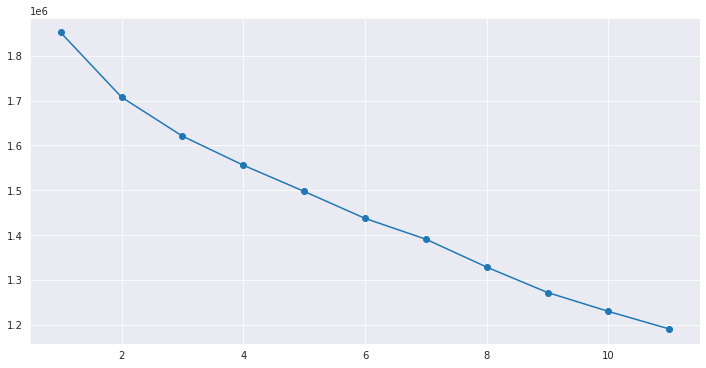

In [583]:

# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

Note:




1.The elbow diagram shows that the gain in explained variance reduces significantly from 3 to 4 to 5. So, optimal number of clusters could either 4 or 5.


2.The actual number of clusters chosen can be finally based on business context and convenience of dealing with number of segments or clusters.

In [584]:
import pickle

# now you can save it to a file
with open('km_4model.pkl', 'wb') as f:
    pickle.dump(km_4, f)

### 4. Predicting Customer Lifetime Value (Low Value/Medium Value/High Value)


####  First define dependent variable with categories low value, medium value, high value using customer revenue.


In [585]:
rfm

,CustomerID,Recency,Frequency,MonetaryValue
0,12346,108,2,121.27
1,12347,60,60,12997.81
2,12348,74,23,1072.69
3,12350,18,17,980.11
4,12356,108,36,1005.30
...,...,...,...,...
1463,18259,271,7,753.80
1464,18260,88,40,2120.88
1465,18269,195,8,54.42
1466,18277,70,1,294.10


In [586]:
quantiles_1 = rfm[['MonetaryValue' ]].quantile(q=[0.33,0.67])
quantiles_1

,MonetaryValue
0.33,759.7334
0.67,2646.5485


In [587]:
# Creating dependent variable 


In [588]:
rfm['Customer_flag_based_on_revenue'] = np.where(rfm.MonetaryValue<=755.3872, 'Low_Value', np.where(rfm.MonetaryValue<=2624.7315, "Medium_Value", "High_Value"))


In [589]:
rfm

,CustomerID,Recency,Frequency,MonetaryValue,Customer_flag_based_on_revenue
0,12346,108,2,121.27,Low_Value
1,12347,60,60,12997.81,High_Value
2,12348,74,23,1072.69,Medium_Value
3,12350,18,17,980.11,Medium_Value
4,12356,108,36,1005.30,Medium_Value
...,...,...,...,...,...
1463,18259,271,7,753.80,Low_Value
1464,18260,88,40,2120.88,Medium_Value
1465,18269,195,8,54.42,Low_Value
1466,18277,70,1,294.10,Low_Value


In [590]:
df_fin_CLTV.columns


Index(['CustomerID', 'Transaction_ID', 'Transaction_Date', 'Product_SKU',
       'Product_Description', 'Product_Category', 'Quantity', 'Avg_Price',
       'Delivery_Charges', 'Coupon_Status', 'Gender', 'Location',
       'Tenure_Months', 'GST', 'tx_Month', 'Month', 'Product_Category ',
       'Coupon_Code', 'Discount_pct', 'Invoice_value'],
      dtype='object')

In [591]:
df_fin_CLTV.head()


,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Gender,Location,Tenure_Months,GST,tx_Month,Month,Product_Category,Coupon_Code,Discount_pct,Invoice_value
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,Jan,Apparel,SALE10,10,150.31
1,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,Jan,Nest-USA,ELEC10,10,150.31
2,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,Jan,Office,OFF10,10,150.31
3,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,Jan,Drinkware,EXTRA10,10,150.31
4,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,Jan,Lifestyle,EXTRA10,10,150.31


In [592]:
#df_fin['Invoice_value'] = df_fin['Quantity']*df_fin['Avg_Price']*1-df_fin['Discount_pct']*1+df_fin['GST']+df_fin.Delivery_Charges


In [593]:
customer_level_data = df_fin_CLTV.groupby(['CustomerID','Location','Gender']).agg({'Transaction_Date': min, 'Quantity' : sum, 'Avg_Price': sum , 'Delivery_Charges': sum, 'GST': sum}).reset_index()


In [594]:
customer_level_data.head()


,CustomerID,Location,Gender,Transaction_Date,Quantity,Avg_Price,Delivery_Charges,GST
0,12346,New York,F,2019-09-15,51,433.33,2550.00,4.76
1,12347,New York,M,2019-03-24,5814,63684.72,11307.38,132.09
2,12348,California,M,2019-06-22,3553,5720.84,3351.55,58.14
3,12350,California,M,2019-12-14,357,22310.80,2173.96,36.72
4,12356,Chicago,F,2019-09-15,952,21162.11,10837.33,90.78


In [595]:
data_final = pd.merge(customer_level_data, rfm, on = "CustomerID", how= "left")
data_final.Customer_flag_based_on_revenue.value_counts()

Medium_Value    497
High_Value      488
Low_Value       483
Name: Customer_flag_based_on_revenue, dtype: int64

In [596]:
data_final.isna().sum()


CustomerID                        0
Location                          0
Gender                            0
Transaction_Date                  0
Quantity                          0
Avg_Price                         0
Delivery_Charges                  0
GST                               0
Recency                           0
Frequency                         0
MonetaryValue                     0
Customer_flag_based_on_revenue    0
dtype: int64

In [597]:
data_final.duplicated().sum()


0

In [598]:
data_final.columns


Index(['CustomerID', 'Location', 'Gender', 'Transaction_Date', 'Quantity',
       'Avg_Price', 'Delivery_Charges', 'GST', 'Recency', 'Frequency',
       'MonetaryValue', 'Customer_flag_based_on_revenue'],
      dtype='object')

In [599]:
# We already created dummies for Location, Gender, Coupan_Status 
data_final.dtypes

CustomerID                                 int64
Location                                  object
Gender                                    object
Transaction_Date                  datetime64[ns]
Quantity                                   int64
Avg_Price                                float64
Delivery_Charges                         float64
GST                                      float64
Recency                                    int64
Frequency                                  int64
MonetaryValue                            float64
Customer_flag_based_on_revenue            object
dtype: object

In [600]:
data_final.nunique()


CustomerID                        1468
Location                             5
Gender                               2
Transaction_Date                   345
Quantity                           436
Avg_Price                         1440
Delivery_Charges                  1152
GST                                783
Recency                            335
Frequency                          165
MonetaryValue                     1464
Customer_flag_based_on_revenue       3
dtype: int64

In [601]:
data_final.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1468 entries, 0 to 1467
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   CustomerID                      1468 non-null   int64         
 1   Location                        1468 non-null   object        
 2   Gender                          1468 non-null   object        
 3   Transaction_Date                1468 non-null   datetime64[ns]
 4   Quantity                        1468 non-null   int64         
 5   Avg_Price                       1468 non-null   float64       
 6   Delivery_Charges                1468 non-null   float64       
 7   GST                             1468 non-null   float64       
 8   Recency                         1468 non-null   int64         
 9   Frequency                       1468 non-null   int64         
 10  MonetaryValue                   1468 non-null   float64       
 11  Cust

In [602]:
data_final.columns   # As dummy creation already done for product_category, coupon_status, gender, location


Index(['CustomerID', 'Location', 'Gender', 'Transaction_Date', 'Quantity',
       'Avg_Price', 'Delivery_Charges', 'GST', 'Recency', 'Frequency',
       'MonetaryValue', 'Customer_flag_based_on_revenue'],
      dtype='object')

In [603]:
data_final.head()


,CustomerID,Location,Gender,Transaction_Date,Quantity,Avg_Price,Delivery_Charges,GST,Recency,Frequency,MonetaryValue,Customer_flag_based_on_revenue
0,12346,New York,F,2019-09-15,51,433.33,2550.00,4.76,108,2,121.27,Low_Value
1,12347,New York,M,2019-03-24,5814,63684.72,11307.38,132.09,60,60,12997.81,High_Value
2,12348,California,M,2019-06-22,3553,5720.84,3351.55,58.14,74,23,1072.69,Medium_Value
3,12350,California,M,2019-12-14,357,22310.80,2173.96,36.72,18,17,980.11,Medium_Value
4,12356,Chicago,F,2019-09-15,952,21162.11,10837.33,90.78,108,36,1005.30,Medium_Value


In [604]:
data_final.drop(['CustomerID', 'Transaction_Date'], axis =1 , inplace = True) # Dropping variables 'CustomerID', 'Transaction_Date', invoice_value


In [605]:
data_final.head()


,Location,Gender,Quantity,Avg_Price,Delivery_Charges,GST,Recency,Frequency,MonetaryValue,Customer_flag_based_on_revenue
0,New York,F,51,433.33,2550.00,4.76,108,2,121.27,Low_Value
1,New York,M,5814,63684.72,11307.38,132.09,60,60,12997.81,High_Value
2,California,M,3553,5720.84,3351.55,58.14,74,23,1072.69,Medium_Value
3,California,M,357,22310.80,2173.96,36.72,18,17,980.11,Medium_Value
4,Chicago,F,952,21162.11,10837.33,90.78,108,36,1005.30,Medium_Value


#### Creating dummies


In [606]:
data_final = create_dummies(data_final, ['Location','Gender'])


In [607]:
data_final


,Quantity,Avg_Price,Delivery_Charges,GST,Recency,Frequency,MonetaryValue,Customer_flag_based_on_revenue,Location_Chicago,Location_New Jersey,Location_New York,Location_Washington DC,Gender_F,Gender_M
0,51,433.33,2550.00,4.76,108,2,121.27,Low_Value,0,0,1,0,1,0
1,5814,63684.72,11307.38,132.09,60,60,12997.81,High_Value,0,0,1,0,0,1
2,3553,5720.84,3351.55,58.14,74,23,1072.69,Medium_Value,0,0,0,0,0,1
3,357,22310.80,2173.96,36.72,18,17,980.11,Medium_Value,0,0,0,0,0,1
4,952,21162.11,10837.33,90.78,108,36,1005.30,Medium_Value,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,782,1440.41,4731.61,19.21,271,7,753.80,Low_Value,0,0,0,0,1,0
1464,2397,18953.13,10751.14,91.97,88,40,2120.88,Medium_Value,0,0,1,0,0,1
1465,170,1518.78,875.50,23.12,195,8,54.42,Low_Value,1,0,0,0,0,1
1466,34,2533.00,102.00,1.70,70,1,294.10,Low_Value,1,0,0,0,1,0


In [608]:
#splitting 
X = data_final.drop(columns = ['Customer_flag_based_on_revenue'])
y = data_final["Customer_flag_based_on_revenue"]

In [609]:
y

0          Low_Value
1         High_Value
2       Medium_Value
3       Medium_Value
4       Medium_Value
            ...     
1463       Low_Value
1464    Medium_Value
1465       Low_Value
1466       Low_Value
1467      High_Value
Name: Customer_flag_based_on_revenue, Length: 1468, dtype: object

In [610]:
#Encoder for y variable
enc =LabelEncoder()
y = enc.fit_transform(y)
X

,Quantity,Avg_Price,Delivery_Charges,GST,Recency,Frequency,MonetaryValue,Location_Chicago,Location_New Jersey,Location_New York,Location_Washington DC,Gender_F,Gender_M
0,51,433.33,2550.00,4.76,108,2,121.27,0,0,1,0,1,0
1,5814,63684.72,11307.38,132.09,60,60,12997.81,0,0,1,0,0,1
2,3553,5720.84,3351.55,58.14,74,23,1072.69,0,0,0,0,0,1
3,357,22310.80,2173.96,36.72,18,17,980.11,0,0,0,0,0,1
4,952,21162.11,10837.33,90.78,108,36,1005.30,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,782,1440.41,4731.61,19.21,271,7,753.80,0,0,0,0,1,0
1464,2397,18953.13,10751.14,91.97,88,40,2120.88,0,0,1,0,0,1
1465,170,1518.78,875.50,23.12,195,8,54.42,1,0,0,0,0,1
1466,34,2533.00,102.00,1.70,70,1,294.10,1,0,0,0,1,0


In [611]:
X

,Quantity,Avg_Price,Delivery_Charges,GST,Recency,Frequency,MonetaryValue,Location_Chicago,Location_New Jersey,Location_New York,Location_Washington DC,Gender_F,Gender_M
0,51,433.33,2550.00,4.76,108,2,121.27,0,0,1,0,1,0
1,5814,63684.72,11307.38,132.09,60,60,12997.81,0,0,1,0,0,1
2,3553,5720.84,3351.55,58.14,74,23,1072.69,0,0,0,0,0,1
3,357,22310.80,2173.96,36.72,18,17,980.11,0,0,0,0,0,1
4,952,21162.11,10837.33,90.78,108,36,1005.30,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,782,1440.41,4731.61,19.21,271,7,753.80,0,0,0,0,1,0
1464,2397,18953.13,10751.14,91.97,88,40,2120.88,0,0,1,0,0,1
1465,170,1518.78,875.50,23.12,195,8,54.42,1,0,0,0,0,1
1466,34,2533.00,102.00,1.70,70,1,294.10,1,0,0,0,1,0


In [612]:
y

array([1, 0, 2, ..., 1, 1, 0])

In [613]:
#pd.Series(y).value_counts()
#balancing the data
#sm = SMOTE()
#resampled_X, resampled_y = sm.fit_resample(X, y)
#X.shape
#y.shape
#resampled_y.shape
#resampled_X.shape
#splitting to train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [614]:
#svc = SVC(kernel='rbf', class_weight='balanced')
from sklearn.svm import SVC

param_grid = {'C': [1]}
grid = GridSearchCV(SVC(), param_grid)

grid.fit(X_train, y_train)
print(grid.best_params_)

{'C': 1}


In [615]:
model = grid.best_estimator_
yfit = model.predict(X_test)

In [616]:
#split training and test sets
#from sklearn.model_selection import KFold, cross_val_score, train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

In [617]:

from sklearn.metrics import classification_report
print(classification_report(y_test, yfit))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89       105
           1       0.88      0.87      0.87        97
           2       0.73      0.77      0.75        92

    accuracy                           0.84       294
   macro avg       0.84      0.84      0.84       294
weighted avg       0.84      0.84      0.84       294



#### XGboost Model


In [618]:
import xgboost as xgb
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(X_test)

Accuracy of XGB classifier on training set: 1.00
Accuracy of XGB classifier on test set: 1.00


In [619]:
from sklearn.model_selection import cross_val_score

cross_val=cross_val_score(ltv_xgb_model,X,y,cv=10,scoring='accuracy').mean()

In [620]:
cross_val


0.9972695927686143

In [621]:
filename = 'SimpleXgboost'
pickle.dump(ltv_xgb_model, open(filename, 'wb'))

#### Tuning XGB Model


In [622]:
from sklearn.model_selection import RandomizedSearchCV


In [623]:
from scipy.stats import randint


In [624]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [625]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

In [626]:
random_classifier = xgb.XGBClassifier()


In [627]:
random_search=RandomizedSearchCV(random_classifier,param_distributions=params,n_iter=5,n_jobs=-1,cv=5,verbose=3)


In [628]:
from sklearn import preprocessing
z = preprocessing.label_binarize(y, classes=[0, 1, 2, 3])

In [629]:
random_search.fit(X, y)
print(random_search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.5}


In [630]:
random_search.best_score_


0.9972765898168141

In [631]:
tuned_xgb = xgb.XGBClassifier(min_child_weight=5,max_depth=4,learning_rate=0.05,gamma=0.0,colsample_bytree=0.4)


In [632]:
tuned_xgb.fit(X_train,y_train)


XGBClassifier(colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=4,
              min_child_weight=5, objective='multi:softprob')

In [633]:
y_pred = tuned_xgb.predict(X_test)


In [634]:
y_pred

array([0, 1, 1, 1, 0, 0, 1, 1, 1, 2, 1, 0, 2, 0, 0, 0, 2, 2, 1, 2, 2, 1,
       1, 1, 2, 1, 2, 2, 1, 0, 1, 0, 0, 0, 0, 2, 1, 1, 2, 1, 1, 2, 1, 2,
       2, 0, 1, 2, 2, 2, 0, 0, 1, 0, 0, 1, 0, 1, 2, 2, 2, 0, 0, 2, 0, 2,
       0, 2, 0, 0, 0, 2, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 2, 1, 2, 0, 1, 2, 2, 2, 1, 1, 0, 0, 0, 0, 2, 0, 2,
       2, 2, 2, 2, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 2, 1, 1, 0, 2, 1,
       1, 0, 1, 1, 0, 2, 2, 1, 2, 2, 0, 0, 2, 0, 1, 1, 1, 2, 0, 0, 2, 2,
       1, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 2,
       0, 0, 0, 2, 0, 2, 1, 0, 2, 0, 1, 1, 0, 1, 2, 0, 1, 0, 0, 1, 1, 2,
       2, 0, 0, 0, 2, 2, 1, 0, 0, 2, 0, 2, 0, 0, 2, 0, 1, 0, 2, 1, 0, 0,
       2, 0, 0, 0, 1, 2, 0, 2, 2, 1, 2, 0, 1, 1, 2, 1, 2, 1, 2, 0, 2, 2,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 2, 2, 1, 0, 0, 0, 1, 1, 1, 2, 2, 2,
       0, 0, 1, 2, 2, 0, 2, 2, 2, 1, 0, 2, 2, 2, 0, 1, 2, 2, 1, 0, 2, 1,
       1, 2, 2, 1, 0, 1, 1, 1])

In [635]:
from sklearn.metrics import confusion_matrix,accuracy_score
cm = confusion_matrix(y_test, y_pred)

accuracy_score=accuracy_score(y_test,y_pred)

In [636]:
accuracy_score


1.0

In [637]:

from sklearn.model_selection import cross_val_score

cross_val=cross_val_score(tuned_xgb,X,y,cv=10,scoring='accuracy').mean()

In [638]:
cross_val

0.9972695927686143

In [639]:
filename = 'TunedXgboost'
pickle.dump(tuned_xgb, open(filename, 'wb'))

## 5. Cross-Selling (Which products are selling together)

### You can perform exploratory analysis & market basket analysis to understand which of items can be bundled together.

In [640]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [641]:
df_fin3.head()


,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Gender,Location,Tenure_Months,GST,tx_Month,Month,Product_Category,Coupon_Code,Discount_pct,Invoice_value
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,Jan,Apparel,SALE10,10,150.31
1,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,Jan,Nest-USA,ELEC10,10,150.31
2,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,Jan,Office,OFF10,10,150.31
3,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,Jan,Drinkware,EXTRA10,10,150.31
4,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,Jan,Lifestyle,EXTRA10,10,150.31


In [642]:
# Clean up spaces in description and remove any rows that don't have a valid invoice
df_fin3['Product_Description'] = df['Product_Description'].str.strip()
df_fin3.dropna(axis=0, subset=['Transaction_ID'], inplace=True)

In [643]:
df_fin3.head()


,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Gender,Location,Tenure_Months,GST,tx_Month,Month,Product_Category,Coupon_Code,Discount_pct,Invoice_value
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,Jan,Apparel,SALE10,10,150.31
1,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,Jan,Nest-USA,ELEC10,10,150.31
2,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,Jan,Office,OFF10,10,150.31
3,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,Jan,Drinkware,EXTRA10,10,150.31
4,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,Jan,Lifestyle,EXTRA10,10,150.31


In [644]:
#Drop the rows that don’t have invoice numbers and remove the credit transactions (those with invoice numbers containing C).
df_fin3['Transaction_ID'] = df_fin3['Transaction_ID'].astype('str')

In [645]:
#To keeping data set is small location= Chicago
basket = (df_fin3[df_fin3['Location'] =="Chicago"].groupby(['Transaction_ID', 'Product_Description'])['Quantity'].sum()
          .unstack().reset_index().fillna(0).set_index('Transaction_ID'))

basket.head()

Product_Description,1 oz Hand Sanitizer,20 oz Stainless Steel Insulated Tumbler,22 oz Android Bottle,22 oz YouTube Bottle Infuser,23 oz Wide Mouth Sport Bottle,24 oz YouTube Sergeant Stripe Bottle,25L Classic Rucksack,26 oz Double Wall Insulated Bottle,7&quot; Dog Frisbee,8 pc Android Sticker Sheet,...,YouTube Trucker Hat,YouTube Twill Cap,YouTube Women's Favorite Tee White,YouTube Women's Fleece Hoodie Black,YouTube Women's Short Sleeve Hero Tee Charcoal,YouTube Women's Short Sleeve Tri-blend Badge Tee Charcoal,YouTube Women's Short Sleeve Tri-blend Badge Tee Grey,YouTube Womens 3/4 Sleeve Baseball Raglan White/Black,YouTube Wool Heather Cap Heather/Black,YouTube Youth Short Sleeve Tee Red
Transaction_ID,,,,,,,,,,,,,,,,,,,,,
16679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16692,0.0,0.0,0.0,0.0,442.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [646]:
#we need to consolidate the items into 1 transaction per row with each product 1 hot encoded.
# Convert the units to 1 hot encoded values
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1  

In [647]:
basket_sets = basket.applymap(encode_units)


In [648]:
# Build up the frequent items
#Now that the data is structured properly, we can generate frequent item sets that have a support of 
#at least 7% (this number was chosen so that I could get enough useful examples):
frequent_itemsets = apriori(basket_sets, min_support=0.001, use_colnames=True)
frequent_itemsets.sort_values(by='support', ascending=False)

,support,itemsets
231,0.136194,(Nest Learning Thermostat 3rd Gen-USA - Stainl...
227,0.123652,(Nest Cam Outdoor Security Camera - USA)
225,0.118592,(Nest Cam Indoor Security Camera - USA)
234,0.052805,(Nest Protect Smoke + CO White Battery Alarm-USA)
232,0.043894,(Nest Learning Thermostat 3rd Gen-USA - White)
...,...,...
417,0.001100,"(Google Men's Vintage Badge Tee Black, Google ..."
310,0.001100,"(8 pc Android Sticker Sheet, YouTube Custom De..."
16,0.001100,(Android Journal Book Set)
309,0.001100,"(Windup Android, 8 pc Android Sticker Sheet)"


In [649]:
#Generate the rules with their corresponding support, confidence and lift:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(1 oz Hand Sanitizer),(Colored Pencil Set),0.005721,0.007591,0.00110,0.192308,25.334448,0.001057,1.228697
1,(Colored Pencil Set),(1 oz Hand Sanitizer),0.007591,0.005721,0.00110,0.144928,25.334448,0.001057,1.162801
2,(1 oz Hand Sanitizer),(Google 22 oz Water Bottle),0.005721,0.024752,0.00143,0.250000,10.100000,0.001289,1.300330
3,(Google 22 oz Water Bottle),(1 oz Hand Sanitizer),0.024752,0.005721,0.00143,0.057778,10.100000,0.001289,1.055249
4,(Google Kick Ball),(1 oz Hand Sanitizer),0.011991,0.005721,0.00176,0.146789,25.659845,0.001692,1.165338
...,...,...,...,...,...,...,...,...,...
403,"(Nest Cam Outdoor Security Camera - USA, Nest ...",(Nest Learning Thermostat 3rd Gen-USA - Stainl...,0.004290,0.136194,0.00121,0.282051,2.070958,0.000626,1.203159
404,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,(Nest Cam Outdoor Security Camera - USA),0.007261,0.123652,0.00121,0.166667,1.347865,0.000312,1.051617
405,(Nest Cam Outdoor Security Camera - USA),(Nest Learning Thermostat 3rd Gen-USA - Stainl...,0.123652,0.007261,0.00121,0.009786,1.347865,0.000312,1.002551
406,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,"(Nest Cam Outdoor Security Camera - USA, Nest ...",0.136194,0.004290,0.00121,0.008885,2.070958,0.000626,1.004636


That’s all there is to it! Build the frequent items using apriori then build the rules with association_rules .


Intrepretation: we can see that there are quite a few rules with a high lift value which means that it occurs more frequently than would be expected given the number of transaction and product combinations. We can also see several where the confidence is high as well. This part of the analysis is where the domain knowledge will come in handy.

In [650]:
rules.sort_values(by='confidence', ascending=False )


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
49,(Android Large Removable Sticker Sheet),(Android Small Removable Sticker Sheet),0.001980,0.003190,0.00121,0.611111,191.551724,0.001204,2.563225
337,(Nest Detect - USA),(Nest Secure Alarm System Starter Pack - USA),0.002200,0.017052,0.00132,0.600000,35.187097,0.001283,2.457371
297,(Google Tote Bag),(Sport Bag),0.002530,0.016612,0.00121,0.478261,28.790671,0.001168,1.884828
294,(Google Tee Green),(Google Tee Blue),0.006161,0.007921,0.00286,0.464286,58.616071,0.002811,1.851881
62,(Android Small Removable Sticker Sheet),(Google Laptop and Cell Phone Stickers),0.003190,0.030693,0.00143,0.448276,14.605117,0.001332,1.756869
...,...,...,...,...,...,...,...,...,...
393,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,(Nest Protect Smoke + CO White Battery Alarm-U...,0.136194,0.005391,0.00165,0.012116,2.247700,0.000916,1.006808
405,(Nest Cam Outdoor Security Camera - USA),(Nest Learning Thermostat 3rd Gen-USA - Stainl...,0.123652,0.007261,0.00121,0.009786,1.347865,0.000312,1.002551
388,(Nest Cam Indoor Security Camera - USA),"(Nest Cam Outdoor Security Camera - USA, Nest ...",0.118592,0.004290,0.00110,0.009276,2.162124,0.000591,1.005033
387,(Nest Cam Outdoor Security Camera - USA),"(Nest Cam Indoor Security Camera - USA, Nest P...",0.123652,0.002640,0.00110,0.008897,3.369662,0.000774,1.006313


In [651]:
# We can filter the dataframe using standard pandas code. In this case, look for a large lift (6) and high confidence (.8):
rules[ (rules['lift'] >= 1) &
       (rules['confidence'] >= 0.1) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(1 oz Hand Sanitizer),(Colored Pencil Set),0.005721,0.007591,0.00110,0.192308,25.334448,0.001057,1.228697
1,(Colored Pencil Set),(1 oz Hand Sanitizer),0.007591,0.005721,0.00110,0.144928,25.334448,0.001057,1.162801
2,(1 oz Hand Sanitizer),(Google 22 oz Water Bottle),0.005721,0.024752,0.00143,0.250000,10.100000,0.001289,1.300330
4,(Google Kick Ball),(1 oz Hand Sanitizer),0.011991,0.005721,0.00176,0.146789,25.659845,0.001692,1.165338
5,(1 oz Hand Sanitizer),(Google Kick Ball),0.005721,0.011991,0.00176,0.307692,25.659845,0.001692,1.427124
...,...,...,...,...,...,...,...,...,...
397,"(Nest Cam Outdoor Security Camera - USA, Nest ...",(Nest Learning Thermostat 3rd Gen-USA - Stainl...,0.007481,0.136194,0.00242,0.323529,2.375511,0.001401,1.276931
398,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,(Nest Cam Outdoor Security Camera - USA),0.008801,0.123652,0.00242,0.275000,2.223977,0.001332,1.208755
402,"(Nest Cam Outdoor Security Camera - USA, Nest ...",(Nest Protect Smoke + CO White Wired Alarm-USA),0.010011,0.042134,0.00121,0.120879,2.868907,0.000788,1.089572
403,"(Nest Cam Outdoor Security Camera - USA, Nest ...",(Nest Learning Thermostat 3rd Gen-USA - Stainl...,0.004290,0.136194,0.00121,0.282051,2.070958,0.000626,1.203159


In looking at the rules, it seems that the outdoor and indoor security camera are purchased together.

#### At this point, you may want to look at how much opportunity there is to use the popularity of one product to drive sales of another. For instance, we can see that we sell 1743 Nest Cam Outdoor Security Camera but only 1450 Nest CAM Indoor Security CAmera - USA so maybe we can drive moreNest CAM Indoor Security CAmera sales through recommendations?

In [652]:
basket['Nest Cam Indoor Security Camera - USA'].sum()


24650.0

In [653]:
basket['Nest Cam Outdoor Security Camera - USA'].sum()


29631.0

#### What is also interesting is to see how the combinations vary by country of purchase. Let’s check out what some popular combinations might be in California

In [654]:
#To keeping data set is small location= Chicago
basket2 = (df_fin3[df_fin3['Location'] =="California"].groupby(['Transaction_ID', 'Product_Description'])['Quantity'].sum()
          .unstack().reset_index().fillna(0).set_index('Transaction_ID'))

In [655]:
basket_sets2 = basket2.applymap(encode_units)
frequent_itemsets2 = apriori(basket_sets2, min_support=0.01, use_colnames=True)

In [656]:
rules2 = association_rules(frequent_itemsets2, metric="lift", min_threshold=1)
rules2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Nest Cam Outdoor Security Camera - USA),(Nest Cam Indoor Security Camera - USA),0.127376,0.120913,0.023954,0.188060,1.555337,0.008553,1.082700
1,(Nest Cam Indoor Security Camera - USA),(Nest Cam Outdoor Security Camera - USA),0.120913,0.127376,0.023954,0.198113,1.555337,0.008553,1.088213


In [657]:
rules2[ (rules2['lift'] >= 1) &
        (rules2['confidence'] >= 0.1) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Nest Cam Outdoor Security Camera - USA),(Nest Cam Indoor Security Camera - USA),0.127376,0.120913,0.023954,0.188060,1.555337,0.008553,1.082700
1,(Nest Cam Indoor Security Camera - USA),(Nest Cam Outdoor Security Camera - USA),0.120913,0.127376,0.023954,0.198113,1.555337,0.008553,1.088213


## 6. Predicting Next Purchase Day(How soon each customer can visit the store (0-30 days, 30-60 days, 60-90 days, 90+ days)

### For this, we need create dependent variable at customer level (average days per one transaction for only repeat customers and divide into groups 0-30 days, 30-60 days, 60-90 days and 90+ days) then build classification model to predict next purchase of given customer

In [658]:
df_fin5 = df



In [659]:
from datetime import datetime, timedelta,date

#import machine learning related libraries
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [660]:
df_fin5.dtypes


CustomerID                      int64
Transaction_ID                 object
Transaction_Date       datetime64[ns]
Product_SKU                    object
Product_Description            object
Product_Category               object
Quantity                        int64
Avg_Price                     float64
Delivery_Charges              float64
Coupon_Status                  object
Gender                         object
Location                       object
Tenure_Months                   int64
GST                           float64
tx_Month                       object
Month                          object
Product_Category               object
Coupon_Code                    object
Discount_pct                    int64
Invoice_value                 float64
dtype: object

In [661]:
#create dataframe with Chicago data only
#df_fin4 = ex_df.query("Location =='Chicago'").reset_index(drop=True) #using .query
df_fin5.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Gender,Location,Tenure_Months,GST,tx_Month,Month,Product_Category,Coupon_Code,Discount_pct,Invoice_value
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,Jan,Apparel,SALE10,10,150.31
1,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,Jan,Nest-USA,ELEC10,10,150.31
2,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,Jan,Office,OFF10,10,150.31
3,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,Jan,Drinkware,EXTRA10,10,150.31
4,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,Jan,Lifestyle,EXTRA10,10,150.31


In [662]:
#Groupby customer id and find min transaction date for each customer
cust_kpi1 = pd.DataFrame(df_fin5.groupby('CustomerID').Transaction_Date.min())
cust_kpi1= cust_kpi1.rename(columns= {'Transaction_Date' : 'First_tx_Date'}).reset_index()
cust_kpi1

,CustomerID,First_tx_Date
0,12346,2019-09-15
1,12347,2019-03-24
2,12348,2019-06-22
3,12350,2019-12-14
4,12356,2019-09-15
...,...,...
1463,18259,2019-04-05
1464,18260,2019-06-22
1465,18269,2019-04-05
1466,18277,2019-10-23


In [663]:
data =  pd.merge(df_fin5, cust_kpi1, on = 'CustomerID', how = 'inner')
data

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,...,Location,Tenure_Months,GST,tx_Month,Month,Product_Category,Coupon_Code,Discount_pct,Invoice_value,First_tx_Date
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,...,Chicago,12,0.1,Jan,Jan,Apparel,SALE10,10,150.31,2019-01-01
1,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,...,Chicago,12,0.1,Jan,Jan,Nest-USA,ELEC10,10,150.31,2019-01-01
2,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,...,Chicago,12,0.1,Jan,Jan,Office,OFF10,10,150.31,2019-01-01
3,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,...,Chicago,12,0.1,Jan,Jan,Drinkware,EXTRA10,10,150.31,2019-01-01
4,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,...,Chicago,12,0.1,Jan,Jan,Lifestyle,EXTRA10,10,150.31,2019-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899703,14600,48497,2019-12-31,GGOENEBQ079099,Nest Protect Smoke + CO White Battery Alarm-USA,Nest-USA,4,80.52,19.99,Clicked,...,California,7,0.1,Dec,Dec,Housewares,HOU30,30,312.17,2019-12-31
899704,14600,48497,2019-12-31,GGOENEBQ079099,Nest Protect Smoke + CO White Battery Alarm-USA,Nest-USA,4,80.52,19.99,Clicked,...,California,7,0.1,Dec,Dec,Accessories,ACC30,30,312.17,2019-12-31
899705,14600,48497,2019-12-31,GGOENEBQ079099,Nest Protect Smoke + CO White Battery Alarm-USA,Nest-USA,4,80.52,19.99,Clicked,...,California,7,0.1,Dec,Dec,Gift Cards,GC30,30,312.17,2019-12-31
899706,14600,48497,2019-12-31,GGOENEBQ079099,Nest Protect Smoke + CO White Battery Alarm-USA,Nest-USA,4,80.52,19.99,Clicked,...,California,7,0.1,Dec,Dec,Notebooks & Journals,NJ30,30,312.17,2019-12-31


In [664]:
#If the invoice date  of customer > min purchase date of that customer  than "existing" otherwise "new". customer
data['customer_type'] = np.where(data.Transaction_Date > data.First_tx_Date, "Repeat", "New")
data2 = data.loc[data.customer_type == 'Repeat'].reset_index(drop =True)
data2.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,...,Tenure_Months,GST,tx_Month,Month,Product_Category,Coupon_Code,Discount_pct,Invoice_value,First_tx_Date,customer_type
0,17850,16877,2019-01-03,GGOEGOCB017499,Leatherette Journal,Office,4,9.07,28.78,Used,...,12,0.1,Jan,Jan,Apparel,SALE10,10,55.16,2019-01-01,Repeat
1,17850,16877,2019-01-03,GGOEGOCB017499,Leatherette Journal,Office,4,9.07,28.78,Used,...,12,0.1,Jan,Jan,Nest-USA,ELEC10,10,55.16,2019-01-01,Repeat
2,17850,16877,2019-01-03,GGOEGOCB017499,Leatherette Journal,Office,4,9.07,28.78,Used,...,12,0.1,Jan,Jan,Office,OFF10,10,55.16,2019-01-01,Repeat
3,17850,16877,2019-01-03,GGOEGOCB017499,Leatherette Journal,Office,4,9.07,28.78,Used,...,12,0.1,Jan,Jan,Drinkware,EXTRA10,10,55.16,2019-01-01,Repeat
4,17850,16877,2019-01-03,GGOEGOCB017499,Leatherette Journal,Office,4,9.07,28.78,Used,...,12,0.1,Jan,Jan,Lifestyle,EXTRA10,10,55.16,2019-01-01,Repeat


In [665]:
#### We got the dataframe for repeat customers only 


In [666]:
tx_6m = data2[(data2.Transaction_Date <datetime.strptime('2019-09-01', '%Y-%m-%d')) & (data2.Transaction_Date >= datetime.strptime('2019-03-01', '%Y-%m-%d'))].reset_index(drop=True)


In [667]:
tx_next = data2[(data2.Transaction_Date >= datetime.strptime('2019-09-01', '%Y-%m-%d')) & (data2.Transaction_Date < datetime.strptime('2019-12-01', '%Y-%m-%d'))].reset_index(drop=True)


In [668]:
tx_user = pd.DataFrame(tx_6m['CustomerID'].unique())
tx_user.columns = ['CustomerID']
tx_user

,CustomerID
0,13047
1,12583
2,15100
3,15291
4,15311
...,...
472,14669
473,17569
474,12652
475,14978


In [669]:
#create a dataframe with customer id and first purchase date in tx_next
tx_next_first_purchase = tx_next.groupby('CustomerID').Transaction_Date.min().reset_index()
tx_next_first_purchase.columns = ['CustomerID','MinPurchaseDate']
tx_next_first_purchase

,CustomerID,MinPurchaseDate
0,12347,2019-11-01
1,12348,2019-10-19
2,12377,2019-11-21
3,12383,2019-09-23
4,12417,2019-10-18
...,...,...
338,18223,2019-09-09
339,18239,2019-10-04
340,18245,2019-11-28
341,18260,2019-10-05


In [670]:
#create a dataframe with customer id and last purchase date in tx_6m
tx_last_purchase_6m = tx_6m.groupby('CustomerID').Transaction_Date.max().reset_index()
tx_last_purchase_6m.columns = ['CustomerID','MaxPurchaseDate']
tx_last_purchase_6m

,CustomerID,MaxPurchaseDate
0,12370,2019-06-25
1,12383,2019-08-24
2,12386,2019-07-28
3,12393,2019-08-31
4,12395,2019-07-20
...,...,...
472,18229,2019-08-30
473,18230,2019-06-12
474,18245,2019-07-05
475,18260,2019-08-11


In [671]:
#merge two dataframes
tx_purchase_dates = pd.merge(tx_last_purchase_6m,tx_next_first_purchase,on='CustomerID',how='left')
tx_purchase_dates

,CustomerID,MaxPurchaseDate,MinPurchaseDate
0,12370,2019-06-25,NaT
1,12383,2019-08-24,2019-09-23
2,12386,2019-07-28,NaT
3,12393,2019-08-31,NaT
4,12395,2019-07-20,NaT
...,...,...,...
472,18229,2019-08-30,NaT
473,18230,2019-06-12,NaT
474,18245,2019-07-05,2019-11-28
475,18260,2019-08-11,2019-10-05


In [672]:
#calculate the time difference in days:
tx_purchase_dates['NextPurchaseDay'] = (tx_purchase_dates['MinPurchaseDate'] - tx_purchase_dates['MaxPurchaseDate']).dt.days
tx_purchase_dates

,CustomerID,MaxPurchaseDate,MinPurchaseDate,NextPurchaseDay
0,12370,2019-06-25,NaT,NaN
1,12383,2019-08-24,2019-09-23,30.0
2,12386,2019-07-28,NaT,NaN
3,12393,2019-08-31,NaT,NaN
4,12395,2019-07-20,NaT,NaN
...,...,...,...,...
472,18229,2019-08-30,NaT,NaN
473,18230,2019-06-12,NaT,NaN
474,18245,2019-07-05,2019-11-28,146.0
475,18260,2019-08-11,2019-10-05,55.0


In [673]:
#merge with tx_user 
tx_user = pd.merge(tx_user, tx_purchase_dates[['CustomerID','NextPurchaseDay']],on='CustomerID',how='left')

In [674]:
#print tx_user
tx_user.head()

,CustomerID,NextPurchaseDay
0,13047,NaN
1,12583,NaN
2,15100,NaN
3,15291,21.0
4,15311,9.0


In [675]:
#fill NA values with 999
tx_user = tx_user.fillna(999)

In [676]:
tx_user.head() #we have NaN values because those customers haven’t made any 
### purchase yet. We fill NaN with 999 to quickly identify them later.

,CustomerID,NextPurchaseDay
0,13047,999.0
1,12583,999.0
2,15100,999.0
3,15291,21.0
4,15311,9.0


### Feature Engineering


In [677]:
# Adding Days between last three purchases like features, we will use shift() method


In [678]:
#create a dataframe with CustomerID and Invoice Date
tx_day_order = tx_6m[['CustomerID','Transaction_Date']]
#convert Invoice Datetime to day
tx_day_order['InvoiceDay'] = tx_6m['Transaction_Date'].dt.date
tx_day_order = tx_day_order.sort_values(['CustomerID','Transaction_Date'])
#drop duplicates
tx_day_order = tx_day_order.drop_duplicates(subset=['CustomerID','InvoiceDay'],keep='first')

<ipython-input-678-641102837aff>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx_day_order['InvoiceDay'] = tx_6m['Transaction_Date'].dt.date


In [679]:
#shifting last 3 purchase dates
tx_day_order['PrevInvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(1)
tx_day_order['T2InvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(2)
tx_day_order['T3InvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(3)

In [680]:
tx_day_order.head()


,CustomerID,Transaction_Date,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate
214200,12370,2019-06-25,2019-06-25,NaN,NaN,NaN
238306,12383,2019-07-14,2019-07-14,NaN,NaN,NaN
238646,12383,2019-08-24,2019-08-24,2019-07-14,NaN,NaN
157454,12386,2019-07-28,2019-07-28,NaN,NaN,NaN
251413,12393,2019-08-31,2019-08-31,NaN,NaN,NaN


In [684]:
tx_day_order['DayDiff'] = (tx_day_order['InvoiceDay'] - tx_day_order['PrevInvoiceDate']).dt.days
tx_day_order['DayDiff2'] = (tx_day_order['InvoiceDay'] - tx_day_order['T2InvoiceDate']).dt.days
tx_day_order['DayDiff3'] = (tx_day_order['InvoiceDay'] - tx_day_order['T3InvoiceDate']).dt.days


In [685]:
tx_day_order.head()


,CustomerID,Transaction_Date,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate,DayDiff,DayDiff2,DayDiff3
214200,12370,2019-06-25,2019-06-25,NaN,NaN,NaN,NaN,NaN,NaN
238306,12383,2019-07-14,2019-07-14,NaN,NaN,NaN,NaN,NaN,NaN
238646,12383,2019-08-24,2019-08-24,2019-07-14,NaN,NaN,41.0,NaN,NaN
157454,12386,2019-07-28,2019-07-28,NaN,NaN,NaN,NaN,NaN,NaN
251413,12393,2019-08-31,2019-08-31,NaN,NaN,NaN,NaN,NaN,NaN


In [682]:
#For each customer ID, we utilize 
# .agg() method to find out the mean and standard deviation of the difference between purchases in days:

In [686]:
tx_day_diff = tx_day_order.groupby('CustomerID').agg({'DayDiff': ['mean','std']}).reset_index()
tx_day_diff.columns = ['CustomerID', 'DayDiffMean','DayDiffStd']

In [687]:
tx_day_order_last = tx_day_order.drop_duplicates(subset=['CustomerID'],keep='last')


In [688]:
tx_day_order_last = tx_day_order_last.dropna()
tx_day_order_last = pd.merge(tx_day_order_last, tx_day_diff, on='CustomerID')
tx_user = pd.merge(tx_user, tx_day_order_last[['CustomerID','DayDiff','DayDiff2','DayDiff3','DayDiffMean','DayDiffStd']], on='CustomerID')
#create tx_class as a copy of tx_user before applying get_dummies
tx_class = tx_user.copy()
tx_class = pd.get_dummies(tx_class)

In [689]:
tx_class

,CustomerID,NextPurchaseDay,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd
0,15100,999.0,16.0,72.0,153.0,39.250000,35.621857
1,15311,9.0,8.0,19.0,35.0,14.100000,7.809538
2,14527,37.0,1.0,25.0,39.0,24.600000,19.768662
3,16029,28.0,42.0,48.0,77.0,25.666667,18.230012
4,17511,999.0,4.0,5.0,50.0,21.500000,31.778924
5,13408,55.0,18.0,59.0,67.0,23.500000,14.011900
6,13767,999.0,26.0,56.0,76.0,28.000000,6.733003
7,13694,84.0,37.0,49.0,65.0,16.500000,15.066519
8,12748,41.0,11.0,12.0,13.0,6.125000,5.636160
9,14911,34.0,1.0,22.0,28.0,12.000000,14.142136


### Selecting a Machine Learning Model


In [690]:
tx_user.NextPurchaseDay.describe()


count     55.000000
mean     464.745455
std      474.893486
min        5.000000
25%       42.000000
50%       91.000000
75%      999.000000
max      999.000000
Name: NextPurchaseDay, dtype: float64

In [691]:
tx_user.NextPurchaseDay


0     999.0
1       9.0
2      37.0
3      28.0
4     999.0
5      55.0
6     999.0
7      84.0
8      41.0
9      34.0
10     14.0
11    999.0
12     71.0
13     18.0
14    999.0
15    999.0
16     23.0
17     56.0
18    999.0
19     25.0
20    999.0
21     56.0
22     95.0
23     54.0
24    999.0
25    999.0
26    999.0
27     18.0
28    999.0
29     64.0
30    999.0
31     32.0
32    999.0
33    999.0
34     38.0
35    101.0
36    113.0
37    999.0
38     74.0
39    999.0
40     75.0
41    999.0
42     91.0
43    999.0
44    999.0
45      5.0
46    999.0
47     31.0
48     43.0
49    999.0
50    999.0
51    999.0
52     63.0
53     76.0
54     61.0
Name: NextPurchaseDay, dtype: float64

In [692]:
tx_class.loc[tx_class.NextPurchaseDay<30,'NextPurchaseDayRange'] = 1
tx_class.loc[(tx_class.NextPurchaseDay>30) & (tx_class.NextPurchaseDay<60),'NextPurchaseDayRange'] = 2
tx_class.loc[(tx_class.NextPurchaseDay>60) & (tx_class.NextPurchaseDay<90),'NextPurchaseDayRange'] = 3
tx_class.loc[tx_class.NextPurchaseDay>90,'NextPurchaseDayRange'] = 4

In [693]:
tx_class


,CustomerID,NextPurchaseDay,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd,NextPurchaseDayRange
0,15100,999.0,16.0,72.0,153.0,39.250000,35.621857,4.0
1,15311,9.0,8.0,19.0,35.0,14.100000,7.809538,1.0
2,14527,37.0,1.0,25.0,39.0,24.600000,19.768662,2.0
3,16029,28.0,42.0,48.0,77.0,25.666667,18.230012,1.0
4,17511,999.0,4.0,5.0,50.0,21.500000,31.778924,4.0
5,13408,55.0,18.0,59.0,67.0,23.500000,14.011900,2.0
6,13767,999.0,26.0,56.0,76.0,28.000000,6.733003,4.0
7,13694,84.0,37.0,49.0,65.0,16.500000,15.066519,3.0
8,12748,41.0,11.0,12.0,13.0,6.125000,5.636160,2.0
9,14911,34.0,1.0,22.0,28.0,12.000000,14.142136,2.0


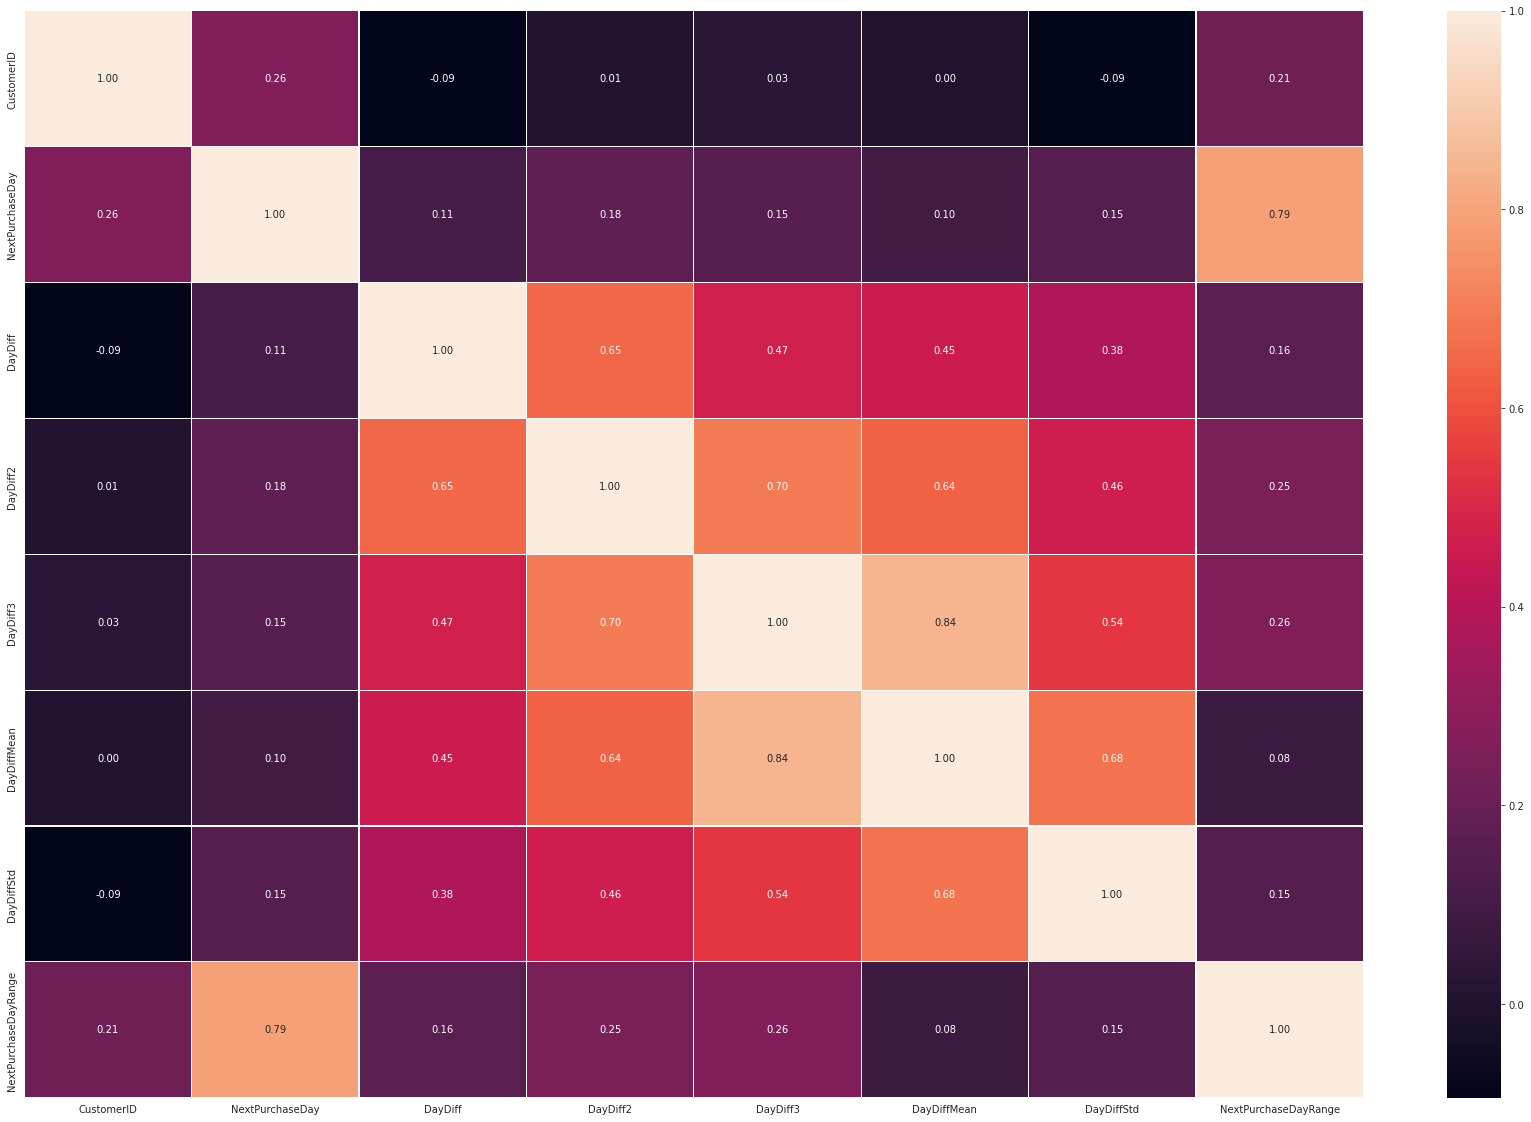

In [694]:
corr = tx_class[tx_class.columns].corr()
plt.figure(figsize = (30,20))
sns.heatmap(corr, annot = True, linewidths=0.2, fmt=".2f")

In [695]:
tx_class.columns


Index(['CustomerID', 'NextPurchaseDay', 'DayDiff', 'DayDiff2', 'DayDiff3',
       'DayDiffMean', 'DayDiffStd', 'NextPurchaseDayRange'],
      dtype='object')

In [696]:
#splitting 
tx_class = tx_class.drop('NextPurchaseDay',axis=1)
X = tx_class.drop(columns = ['NextPurchaseDayRange'])
y = tx_class["NextPurchaseDayRange"]

In [697]:
y

0     4.0
1     1.0
2     2.0
3     1.0
4     4.0
5     2.0
6     4.0
7     3.0
8     2.0
9     2.0
10    1.0
11    4.0
12    3.0
13    1.0
14    4.0
15    4.0
16    1.0
17    2.0
18    4.0
19    1.0
20    4.0
21    2.0
22    4.0
23    2.0
24    4.0
25    4.0
26    4.0
27    1.0
28    4.0
29    3.0
30    4.0
31    2.0
32    4.0
33    4.0
34    2.0
35    4.0
36    4.0
37    4.0
38    3.0
39    4.0
40    3.0
41    4.0
42    4.0
43    4.0
44    4.0
45    1.0
46    4.0
47    2.0
48    2.0
49    4.0
50    4.0
51    4.0
52    3.0
53    3.0
54    3.0
Name: NextPurchaseDayRange, dtype: float64

In [698]:
#Encoder for y variable
enc =LabelEncoder()
y = enc.fit_transform(y)

In [699]:
X

,CustomerID,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd
0,15100,16.0,72.0,153.0,39.250000,35.621857
1,15311,8.0,19.0,35.0,14.100000,7.809538
2,14527,1.0,25.0,39.0,24.600000,19.768662
3,16029,42.0,48.0,77.0,25.666667,18.230012
4,17511,4.0,5.0,50.0,21.500000,31.778924
5,13408,18.0,59.0,67.0,23.500000,14.011900
6,13767,26.0,56.0,76.0,28.000000,6.733003
7,13694,37.0,49.0,65.0,16.500000,15.066519
8,12748,11.0,12.0,13.0,6.125000,5.636160
9,14911,1.0,22.0,28.0,12.000000,14.142136


In [700]:
y

array([3, 0, 1, 0, 3, 1, 3, 2, 1, 1, 0, 3, 2, 0, 3, 3, 0, 1, 3, 0, 3, 1,
       3, 1, 3, 3, 3, 0, 3, 2, 3, 1, 3, 3, 1, 3, 3, 3, 2, 3, 2, 3, 3, 3,
       3, 0, 3, 1, 1, 3, 3, 3, 2, 2, 2])

In [701]:
# Checking balancing of data
tx_class.NextPurchaseDayRange.value_counts()

4.0    28
2.0    11
1.0     8
3.0     8
Name: NextPurchaseDayRange, dtype: int64

In [702]:
#balancing the data
sm= SMOTE()
resampled_X, resampled_y = sm.fit_resample(X, y)

In [703]:
X.shape


(55, 6)

In [704]:
y.shape


(55,)

In [705]:
resampled_X.shape


(112, 6)

In [706]:
resampled_y.shape


(112,)

In [707]:
#train & test split


X_train, X_test, y_train, y_test = train_test_split(resampled_X, resampled_y, test_size=0.2, random_state=44)

In [708]:
#create an array of models
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))

In [709]:
# Measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=2)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

LR [0.33333333 0.27272727]
NB [0.62222222 0.45454545]
RF [0.62222222 0.59090909]
SVC [0.2        0.20454545]
Dtree [0.48888889 0.59090909]
XGB [0.62222222 0.68181818]
KNN [0.37777778 0.47727273]


Multi-Classification Model


In [710]:
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 1.00
Accuracy of XGB classifier on test set: 0.52


XGBClassifier has many parameters. You can find the list of them here. For this example, we will select max_depth and min_child_weight.


In [711]:
from sklearn.model_selection import GridSearchCV
param_test1 = {
 'max_depth':range(1,12,1),
 'min_child_weight':range(1,8,1)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(), 
param_grid = param_test1, scoring='accuracy',n_jobs=-1, cv=2)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 5, 'min_child_weight': 2}, 0.6628787878787878)

In [712]:
xgb_model = xgb.XGBClassifier(max_depth = 1, min_child_weight= 4).fit(X_train, y_train)
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.81
Accuracy of XGB classifier on test set: 0.48


## 7. Perform cohort analysis by defining below cohorts


### Customers who started in each month and understand their behaviour


### Which Month cohort has maximum retention?


In [713]:
def get_month(x) : return dt.datetime(x.year,x.month,1)
df_fin['InvoiceMonth'] = df_fin['Transaction_Date'].apply(get_month)
grouping = df_fin.groupby('CustomerID')['InvoiceMonth']
df_fin['CohortMonth'] = grouping.transform('min')
df_fin.tail()

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Recency,Frequency,MonetaryValue,Deciles,r_seg,f_seg,m_seg,fm_seg,InvoiceMonth,CohortMonth
52919,14410,48493,1,121.30,6.50,45,0.10,30,0,0,...,1,8,921.72,0,Active,1,1,Standard,2019-12-01,2019-12-01
52920,14410,48494,1,48.92,6.50,45,0.18,30,0,1,...,1,8,921.72,0,Active,1,1,Standard,2019-12-01,2019-12-01
52921,14410,48495,1,151.88,6.50,45,0.10,30,0,0,...,1,8,921.72,0,Active,1,1,Standard,2019-12-01,2019-12-01
52922,14600,48496,5,80.52,6.50,7,0.10,30,0,0,...,1,2,691.37,0,Active,1,1,Standard,2019-12-01,2019-12-01
52923,14600,48497,4,80.52,19.99,7,0.10,30,0,0,...,1,2,691.37,0,Active,1,1,Standard,2019-12-01,2019-12-01


In [714]:
def get_month_int (dframe,column):
    year = dframe[column].dt.year
    month = dframe[column].dt.month
    day = dframe[column].dt.day
    return year, month , day 

invoice_year,invoice_month,_ = get_month_int(df_fin,'InvoiceMonth')
cohort_year,cohort_month,_ = get_month_int(df_fin,'CohortMonth')

year_diff = invoice_year - cohort_year 
month_diff = invoice_month - cohort_month 

df_fin['CohortIndex'] = year_diff * 12 + month_diff + 1 

In [715]:
#Count monthly active customers from each cohort
grouping = df_fin.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
# Return number of unique elements in the object.
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='CustomerID')
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,
2019-01-01,215.0,13.0,24.0,34.0,23.0,44.0,35.0,47.0,23.0,28.0,20.0,34.0
2019-02-01,96.0,7.0,9.0,16.0,17.0,22.0,19.0,15.0,12.0,11.0,16.0,NaN
2019-03-01,177.0,18.0,35.0,25.0,32.0,33.0,22.0,22.0,15.0,19.0,NaN,NaN
2019-04-01,163.0,14.0,24.0,24.0,18.0,15.0,10.0,16.0,12.0,NaN,NaN,NaN
2019-05-01,112.0,12.0,9.0,13.0,10.0,13.0,14.0,8.0,NaN,NaN,NaN,NaN
2019-06-01,137.0,20.0,22.0,12.0,11.0,14.0,11.0,NaN,NaN,NaN,NaN,NaN
2019-07-01,94.0,13.0,4.0,6.0,11.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-01,135.0,14.0,15.0,10.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-01,78.0,6.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Retention Table


In [716]:
# Retention table
cohort_size = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_size,axis=0) #axis=0 to ensure the divide along the row axis 
retention.round(3) * 100 #to show the number as percentage 

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,
2019-01-01,100.0,6.0,11.2,15.8,10.7,20.5,16.3,21.9,10.7,13.0,9.3,15.8
2019-02-01,100.0,7.3,9.4,16.7,17.7,22.9,19.8,15.6,12.5,11.5,16.7,NaN
2019-03-01,100.0,10.2,19.8,14.1,18.1,18.6,12.4,12.4,8.5,10.7,NaN,NaN
2019-04-01,100.0,8.6,14.7,14.7,11.0,9.2,6.1,9.8,7.4,NaN,NaN,NaN
2019-05-01,100.0,10.7,8.0,11.6,8.9,11.6,12.5,7.1,NaN,NaN,NaN,NaN
2019-06-01,100.0,14.6,16.1,8.8,8.0,10.2,8.0,NaN,NaN,NaN,NaN,NaN
2019-07-01,100.0,13.8,4.3,6.4,11.7,9.6,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-01,100.0,10.4,11.1,7.4,5.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-01,100.0,7.7,3.8,2.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


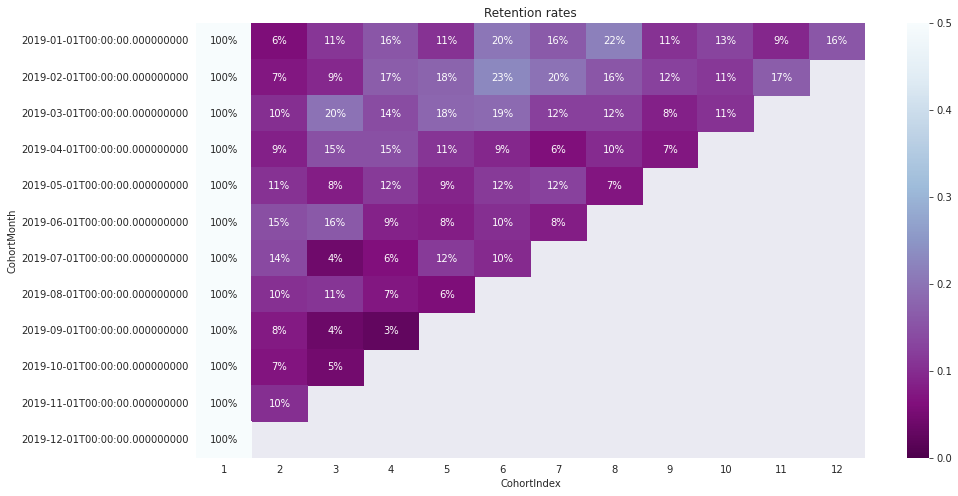

In [717]:
#Build the heatmap
plt.figure(figsize=(15, 8))
plt.title('Retention rates')
sns.heatmap(data=retention,annot = True,fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap="BuPu_r")
plt.show()


Thank You